# IMPORTACIÓN LIBRERIAS


In [1]:
import numpy as np
import pandas as pd
from math import *
import math
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [6]:
import os
import joblib


SEED = 42
np.random.seed(SEED)

# ML libs
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_score,
    brier_score_loss, confusion_matrix, f1_score, recall_score
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# imbalanced
from imblearn.over_sampling import SMOTE

# LightGBM
import lightgbm as lgb

# SHAP
import shap

# CARGA DE ARCHIVOS

In [2]:
def load_dataset(file_path, file_type=None, separator=None, encoding='utf-8', **kwargs):
    """
    Loads a dataset in different formats, with support for custom separators, encoding, and more options.
    """
    # If the file type is not specified, infer from file extension
    if not file_type:
        file_type = file_path.split('.')[-1].lower()

    # Load according to the file type
    if file_type == 'csv':
        return pd.read_csv(file_path, sep=separator or ',', encoding=encoding, **kwargs)
    elif file_type in ['xls', 'xlsx']:
        return pd.read_excel(file_path, **kwargs)
    elif file_type == 'json':
        return pd.read_json(file_path, encoding=encoding, **kwargs)
    else:
        raise ValueError(f"File format '{file_type}' not supported. Use 'csv', 'excel', or 'json'.")

Cargamos el archivo final para acabar de prepararlo y empezar con el modelo


In [3]:
df = load_dataset('../data/dataframe_final_abonado.csv')
df

,IdPersona,Edad,FechaInscripcion,TipoAbonoActual,Sexo_Mujer,FAntiguedad,NumAltasAntesDelPeriodo,TuvoAltasPrevias,MesesDesdeUltimaAltaPrevia,MesesDuracionAbonoActual,...,DiaFav_lunes,DiaFav_martes,DiaFav_miércoles,DiaFav_sábado,DiaFav_viernes,EstFav_invierno,EstFav_otono,EstFav_primavera,EstFav_verano,TieneAccesos
0,117538,10,2025-09-01,AM00,True,2025-09-01,0.0,False,-1.0,0.0,...,False,False,False,False,False,False,False,False,False,False
1,109390,57,2025-09-01,MA00,True,2022-06-20,0.0,False,-1.0,0.0,...,False,False,False,False,False,True,False,False,False,True
2,116058,35,2025-09-01,AA00,True,2025-02-15,0.0,False,-1.0,0.0,...,True,False,False,False,False,False,False,True,False,True
3,96089,46,2025-09-01,AC03,False,2018-03-15,1.0,True,77.0,0.0,...,False,False,True,False,False,False,False,False,True,True
4,96101,49,2025-09-01,AA00,True,2025-09-01,0.0,False,-1.0,0.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7816,117275,51,2025-08-06,AA00,False,2025-08-06,-1.0,False,-1.0,-1.0,...,True,False,False,False,False,False,False,False,True,True
7817,117276,37,2025-08-06,AA00,True,2025-08-06,-1.0,False,-1.0,-1.0,...,True,False,False,False,False,False,False,False,True,True
7818,117277,7,2025-08-06,AM00,False,2025-08-06,-1.0,False,-1.0,-1.0,...,False,False,False,False,False,False,False,False,True,True
7819,117282,36,2025-08-07,AA00,False,2025-08-07,-1.0,False,-1.0,-1.0,...,False,True,False,False,False,False,False,False,True,True


## DEA

In [4]:
print("Shape:", df.shape)

Shape: (7821, 82)


Se filtra el dataframe preparado para quedarse con los clientes que son mayores de edad, ya que son los que tienen poder de decision propia y no dependen de otros para decidir si se apuntan o no en el gimnasio. Caso de los manores de edad

In [22]:
df_clientes_adultos= df[df['Edad']>=18].reset_index(drop=True)

In [29]:
print("Shape:", df_clientes_adultos.shape)

Shape: (6929, 82)


In [30]:
display(df_clientes_adultos.info(verbose=True, show_counts=True))  # muestra tipos y NA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6929 entries, 0 to 6928
Data columns (total 82 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   IdPersona                            6929 non-null   int64  
 1   Edad                                 6929 non-null   int64  
 2   FechaInscripcion                     6929 non-null   object 
 3   TipoAbonoActual                      6929 non-null   object 
 4   Sexo_Mujer                           6929 non-null   bool   
 5   FAntiguedad                          6929 non-null   object 
 6   NumAltasAntesDelPeriodo              6929 non-null   float64
 7   TuvoAltasPrevias                     6929 non-null   bool   
 8   MesesDesdeUltimaAltaPrevia           6929 non-null   float64
 9   MesesDuracionAbonoActual             6929 non-null   float64
 10  NumAltasEnPeriodo                    6929 non-null   float64
 11  MesesDesdePrimeraAltaEnPeriodo

None

In [31]:
df = df_clientes_adultos.rename(columns= {'EsChurn': 'Abandono'})
display(df.info(verbose=True, show_counts=True))  # muestra tipos y NA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6929 entries, 0 to 6928
Data columns (total 82 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   IdPersona                            6929 non-null   int64  
 1   Edad                                 6929 non-null   int64  
 2   FechaInscripcion                     6929 non-null   object 
 3   TipoAbonoActual                      6929 non-null   object 
 4   Sexo_Mujer                           6929 non-null   bool   
 5   FAntiguedad                          6929 non-null   object 
 6   NumAltasAntesDelPeriodo              6929 non-null   float64
 7   TuvoAltasPrevias                     6929 non-null   bool   
 8   MesesDesdeUltimaAltaPrevia           6929 non-null   float64
 9   MesesDuracionAbonoActual             6929 non-null   float64
 10  NumAltasEnPeriodo                    6929 non-null   float64
 11  MesesDesdePrimeraAltaEnPeriodo

None

In [32]:
sns.set(style='whitegrid', context='notebook')

# Ajustes
ID_COL = 'IdPersona'
TARGET = 'Abandono'
RANDOM_STATE = 42
plt.rcParams['figure.figsize'] = (10,5)

In [33]:
def analizar_target_abandono(df, target_col='Abandono', figsize=(10, 5), style='whitegrid', context='notebook'):
    """
    Muestra un análisis simple del target (churn), incluyendo conteo, proporciones y un gráfico.
    
    Parámetros:
    - df: DataFrame de entrada.
    - target_col: nombre de la columna objetivo (por defecto: 'Abandono').
    - figsize: tamaño de la figura (tupla).
    - style: estilo de seaborn (por defecto: 'whitegrid').
    - context: contexto de seaborn (por defecto: 'notebook').
    """
    
    # Estilo visual
    sns.set(style=style, context=context)
    plt.rcParams['figure.figsize'] = figsize
    
    # Conteo y proporciones
    print('🔹 Target counts:')
    print(df[target_col].value_counts(dropna=False))
    
    print('\n🔹 Target proportion:')
    print(df[target_col].value_counts(normalize=True))
    
    # Gráfico
    sns.countplot(data=df, x=target_col, palette='pastel')
    plt.title('Distribución del Target (Abandono)', fontsize=14)
    plt.xlabel(target_col)
    plt.ylabel('Frecuencia')
    plt.show()

🔹 Target counts:
Abandono
0    4425
1    2504
Name: count, dtype: int64

🔹 Target proportion:
Abandono
0    0.63862
1    0.36138
Name: proportion, dtype: float64


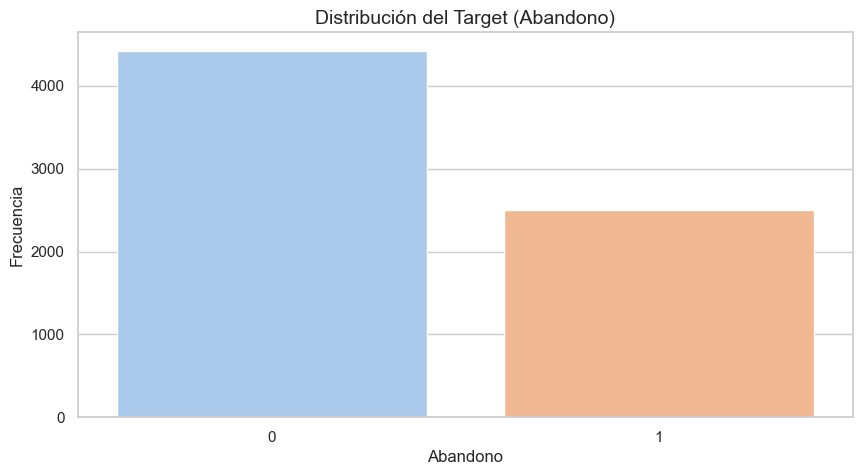

In [34]:
analizar_target_abandono(df, target_col='Abandono')

In [35]:
def calcular_correlaciones_abandono(df, target_col='Abandono', top_n=None):
    """
    Calcula las correlaciones de todas las variables numéricas con el target.

    Parámetros:
    - df: DataFrame de entrada.
    - target_col: columna objetivo (por defecto: 'Abandono').
    - top_n: número de variables con mayor correlación a mostrar (si se desea limitar).

    Retorna:
    - Series con correlaciones ordenadas descendente (más correladas arriba).
    """
    # Asegurar que el target esté en formato numérico
    df[target_col] = df[target_col].astype(int)

    # Seleccionar columnas numéricas (incluye el target)
    df_num = df.select_dtypes(include=['number'])

    # Calcular correlaciones con el target
    correlaciones = df_num.corr()[target_col].sort_values(ascending=False)

    # Mostrar top_n si se desea
    if top_n is not None:
        correlaciones = correlaciones.head(top_n)

    print(f"🔹 Correlaciones con '{target_col}':")
    print(correlaciones)

    return correlaciones

In [36]:
correlaciones = calcular_correlaciones_abandono(df, top_n=80)

🔹 Correlaciones con 'Abandono':
Abandono                               1.000000
NumBajasEnPeriodo                      0.952792
MesesDesdeUltimaBaja                   0.757523
DiasDesdeUltima                        0.426366
IdPersona                              0.202228
PropUlt90                              0.182010
PctPagoTarjeta                         0.061361
PctPagoMetalico                        0.052884
DeltaDuracionUlt90VsTotal              0.042115
PctPagoTransferencia                   0.039135
SemanasConVisitaRatio                  0.004489
StdIntervaloMeses                      0.002076
FrecuenciaModal                       -0.004351
PropVisitasFestivo                    -0.020323
TipoServicio_ENTRENAMENTS PERSONALS   -0.021333
TipoServicio_NUTRICIÓ                 -0.021656
Importe_total_pagado_servicios        -0.023826
ratio_importe_2025_2024               -0.026849
TipoServicio_FISIOTERÀPIA             -0.032614
ratio_cantidad_2025_2024              -0.034137
Cantidad

In [37]:
def calcular_correlacion_bool(df: pd.DataFrame, objetivo: str = 'Abandono') -> pd.Series:
    """
    Calcula la correlación de variables booleanas con la variable objetivo.
    
    Parámetros:
        df (pd.DataFrame): DataFrame con las columnas booleanas y la variable objetivo.
        objetivo (str): Nombre de la variable objetivo (por defecto 'abandono').
    
    Retorna:
        pd.Series: Correlación de cada variable booleana con la variable objetivo,
                   ordenada de mayor a menor, sin incluir la variable objetivo.
    """
    # Seleccionar columnas booleanas
    bool_cols = df.select_dtypes(include='bool').columns.tolist()

    # Asegurarse de que la variable objetivo esté incluida
    if objetivo not in bool_cols:
        bool_cols.append(objetivo)
    
    # Convertir a int (0/1)
    df_corr = df[bool_cols].astype(int)

    # Calcular correlación y ordenar
    correlation = df_corr.corr()[objetivo].drop(objetivo).sort_values(ascending=False)
    return correlation

In [16]:
correlation = calcular_correlacion_bool(df, objetivo='Abandono')
print(correlation)

EstFav_otono                     0.128285
EstFav_invierno                  0.035887
Sexo_Mujer                       0.016705
DiaFav_jueves                   -0.003636
Uso_entrenamientos_personales   -0.018325
DiaFav_miércoles                -0.019982
Uso_nutricion                   -0.021403
DiaFav_sábado                   -0.028643
Uso_fisioterapia                -0.030973
DiaFav_martes                   -0.035148
UsoServiciosExtra               -0.035929
DiaFav_domingo                  -0.036498
DiaFav_viernes                  -0.044537
DiaFav_lunes                    -0.083921
EstFav_primavera                -0.108667
TieneAccesos                    -0.215207
EstFav_verano                   -0.247283
TienePagos                      -0.297565
TuvoAltasPrevias                -0.547586
Name: Abandono, dtype: float64


In [38]:
# Resumen numérico básico
display(df.describe(include='number').T)

# Resumen categórico básico
display(df.describe(include=['object','category','bool']).T)

,count,mean,std,min,25%,50%,75%,max
IdPersona,6929.0,99793.811517,25218.681899,334.000000,97563.000000,108383.000000,114291.000000,117427.000000
Edad,6929.0,45.226873,17.024814,18.000000,31.000000,45.000000,57.000000,97.000000
NumAltasAntesDelPeriodo,6929.0,0.001443,0.866357,-1.000000,-1.000000,0.000000,1.000000,3.000000
MesesDesdeUltimaAltaPrevia,6929.0,14.509020,39.288971,-1.000000,-1.000000,-1.000000,11.000000,827.000000
MesesDuracionAbonoActual,6929.0,19.484630,41.292552,-1.000000,-1.000000,3.000000,22.000000,839.000000
NumAltasEnPeriodo,6929.0,-0.157454,0.735249,-1.000000,-1.000000,0.000000,0.000000,1.000000
MesesDesdePrimeraAltaEnPeriodo,6929.0,0.261365,3.028913,-1.000000,-1.000000,-1.000000,-1.000000,12.000000
Abandono,6929.0,0.361380,0.480435,0.000000,0.000000,0.000000,1.000000,1.000000
VidaGymMeses,6929.0,25.132169,43.960096,0.000000,3.133333,10.133333,27.400000,839.500000
NumBajasEnPeriodo,6929.0,0.386059,0.538674,0.000000,0.000000,0.000000,1.000000,3.000000


,count,unique,top,freq
FechaInscripcion,6929,1214,2025-09-01,308
TipoAbonoActual,6929,45,AA00,2587
Sexo_Mujer,6929,2,True,3834
FAntiguedad,6929,1968,2025-09-01,76
TuvoAltasPrevias,6929,2,False,4503
FechaFin,6929,47,2025-09-01,4703
FechaUltimaBajaEnPeriodo,2504,38,2025-09-01,303
UsoServiciosExtra,6929,2,False,6893
Uso_entrenamientos_personales,6929,2,False,6912
Uso_fisioterapia,6929,2,False,6916


In [39]:
# 1) Detectar tipos automáticamente (pero comprueba manualmente)
def detect_types(df, id_col=ID_COL, target=TARGET):
    excl = {id_col, target}
    cols = [c for c in df.columns if c not in excl]
    bool_cols = df.select_dtypes(include=['bool']).columns.tolist()
    # detectar 0/1 como booleano
    for c in cols:
        if c in bool_cols: 
            continue
        vals = df[c].dropna().unique()
        if set(vals).issubset({0,1}):
            bool_cols.append(c)
    cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
    # ints with low cardinality -> categorical
    for c in df.select_dtypes(include=['int64','Int64']).columns:
        if c not in bool_cols and c not in cat_cols:
            if df[c].nunique() < 30 and c not in excl:
                cat_cols.append(c)
    num_cols = [c for c in df.select_dtypes(include=['float64','int64']).columns if c not in cat_cols and c not in bool_cols and c not in excl]
    return num_cols, cat_cols, sorted(list(set(bool_cols)))

num_cols, cat_cols, bool_cols = detect_types(df)
print("Num:", len(num_cols), num_cols)
print("Cat:", len(cat_cols), cat_cols)
print("Bool:", len(bool_cols), bool_cols)

Num: 52 ['Edad', 'NumAltasAntesDelPeriodo', 'MesesDesdeUltimaAltaPrevia', 'MesesDuracionAbonoActual', 'NumAltasEnPeriodo', 'MesesDesdePrimeraAltaEnPeriodo', 'VidaGymMeses', 'NumBajasEnPeriodo', 'MesesDesdeUltimaBaja', 'Importe_total_pagado_servicios', 'Cantidad_total_pagado_servicios', 'TipoServicio_ENTRENAMENTS PERSONALS', 'TipoServicio_NUTRICIÓ', 'ratio_importe_2025_2024', 'ratio_cantidad_2025_2024', 'NumPagosEconomia', 'MediaIntervaloMeses', 'StdIntervaloMeses', 'UltimoPagoMesEconomia', 'PrimerPagoMesEconomia', 'MesesConPagoEconomia', 'PorcentajeMesesPagados', 'TotalPagadoEconomia', 'media_pagoEconomia', 'StdPagoEconomia', 'CoefVarPagoEconomia', 'PctPagoMetalico', 'PctPagoRecibo', 'PctPagoTarjeta', 'NumAbonosDistintos', 'TotalVisitas', 'DiasActivo', 'TiempoActivoDias', 'VisitasUlt30', 'VisitasUlt90', 'VisitasUlt180', 'PropUlt90', 'DiasDesdeUltima', 'tasa_caida_visitas', 'DuracionMediaTotal', 'DuracionMediaUlt90', 'DeltaDuracionUlt90VsTotal', 'StdDiasEntreVisitas', 'FrecuenciaModal',

In [40]:
# Regla rápida (sugerencias)
na_summary = pd.DataFrame({
    'n_missing': df.isna().sum(),
    'pct_missing': df.isna().mean()
}).sort_values('pct_missing', ascending=False)
display(na_summary)

,n_missing,pct_missing
FechaUltimaBajaEnPeriodo,4425,0.63862
IdPersona,0,0.00000
Edad,0,0.00000
FechaInscripcion,0,0.00000
Sexo_Mujer,0,0.00000
...,...,...
EstFav_invierno,0,0.00000
EstFav_otono,0,0.00000
EstFav_primavera,0,0.00000
EstFav_verano,0,0.00000


In [41]:
df

,IdPersona,Edad,FechaInscripcion,TipoAbonoActual,Sexo_Mujer,FAntiguedad,NumAltasAntesDelPeriodo,TuvoAltasPrevias,MesesDesdeUltimaAltaPrevia,MesesDuracionAbonoActual,...,DiaFav_lunes,DiaFav_martes,DiaFav_miércoles,DiaFav_sábado,DiaFav_viernes,EstFav_invierno,EstFav_otono,EstFav_primavera,EstFav_verano,TieneAccesos
0,109390,57,2025-09-01,MA00,True,2022-06-20,0.0,False,-1.0,0.0,...,False,False,False,False,False,True,False,False,False,True
1,116058,35,2025-09-01,AA00,True,2025-02-15,0.0,False,-1.0,0.0,...,True,False,False,False,False,False,False,True,False,True
2,96089,46,2025-09-01,AC03,False,2018-03-15,1.0,True,77.0,0.0,...,False,False,True,False,False,False,False,False,True,True
3,96101,49,2025-09-01,AA00,True,2025-09-01,0.0,False,-1.0,0.0,...,False,False,False,False,False,False,False,False,False,False
4,96304,53,2025-09-01,AA00,True,2021-09-20,0.0,False,-1.0,0.0,...,True,False,False,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6924,117264,57,2025-08-04,AA00,True,2025-08-04,-1.0,False,-1.0,-1.0,...,False,False,False,False,False,False,False,False,False,False
6925,117275,51,2025-08-06,AA00,False,2025-08-06,-1.0,False,-1.0,-1.0,...,True,False,False,False,False,False,False,False,True,True
6926,117276,37,2025-08-06,AA00,True,2025-08-06,-1.0,False,-1.0,-1.0,...,True,False,False,False,False,False,False,False,True,True
6927,117282,36,2025-08-07,AA00,False,2025-08-07,-1.0,False,-1.0,-1.0,...,False,True,False,False,False,False,False,False,True,True


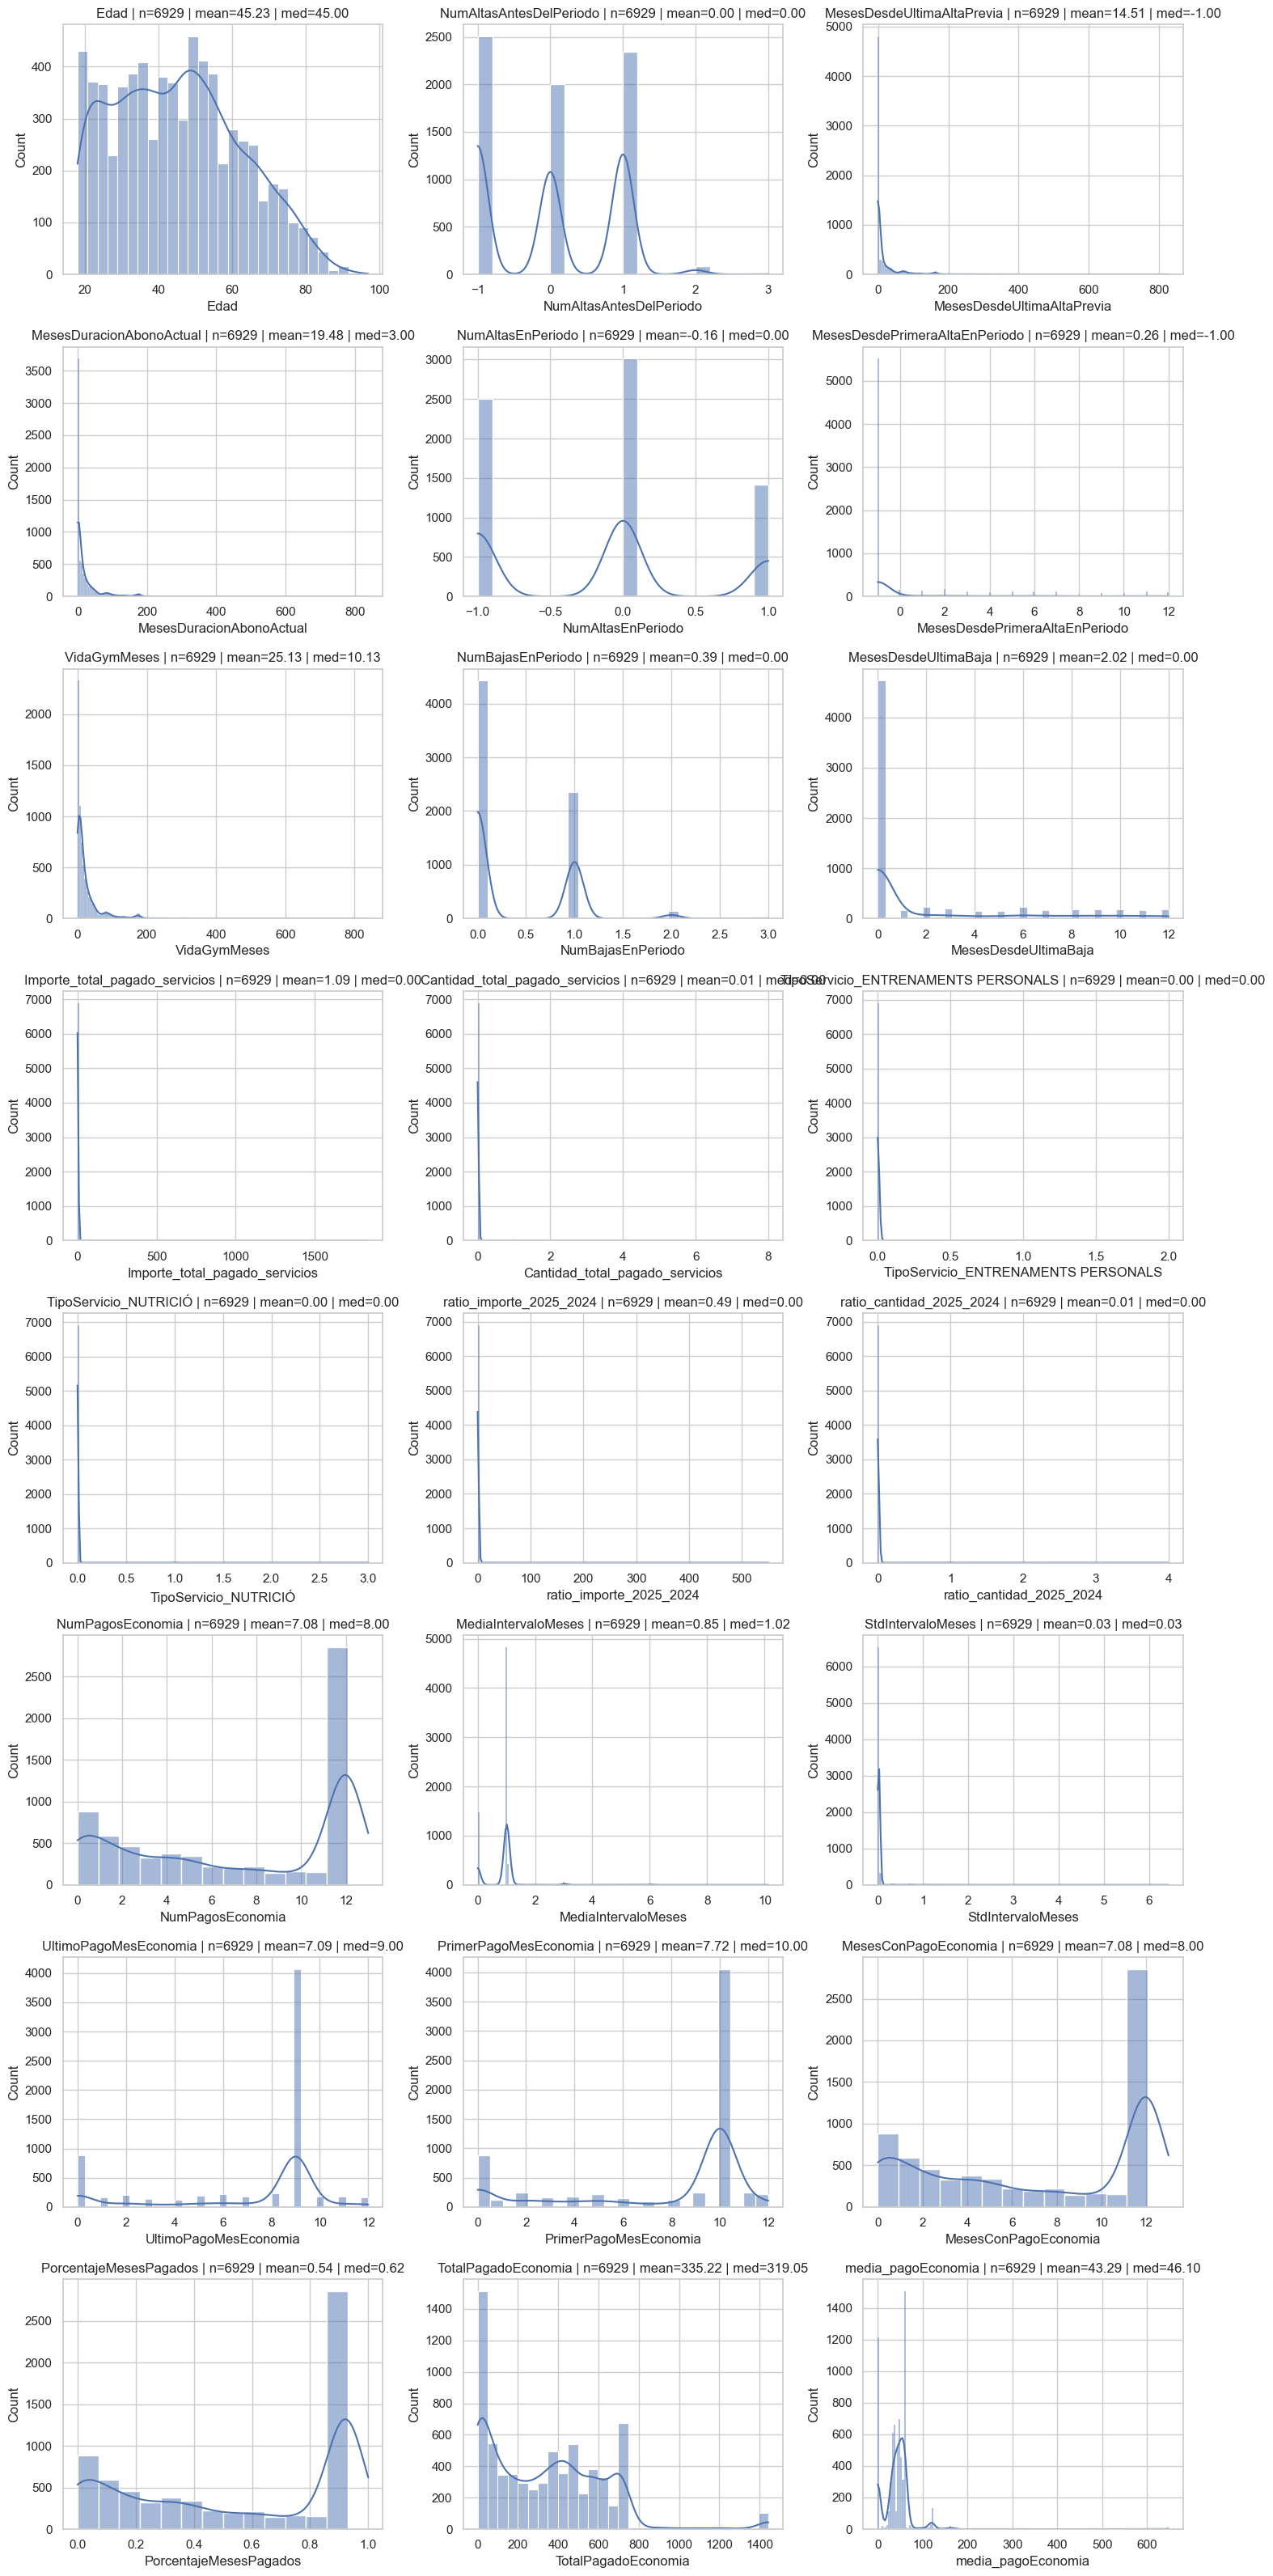

In [42]:
# Función para graficar distribuciones y estadísticas clave
def univariate_num(df, cols, nrows=4, max_plots=24):
    cols = cols[:max_plots]
    n = len(cols)
    ncols = 3
    nrows = int(np.ceil(n/ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
    axes = axes.flatten()
    for i, c in enumerate(cols):
        sns.histplot(df[c].dropna(), kde=True, ax=axes[i])
        axes[i].set_title(f"{c} | n={df[c].notna().sum()} | mean={df[c].mean():.2f} | med={df[c].median():.2f}")
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()

univariate_num(df, num_cols)

In [43]:
def top_freq(df, cols, topk=10):
    for c in cols:
        vc = df[c].value_counts(dropna=False).head(topk)
        print(f"--- {c} (n_unique={df[c].nunique()}) ---")
        display(vc.to_frame('count').assign(pct=lambda x: x['count']/len(df)))
        print()

top_freq(df, cat_cols[:40])
# Booleanas: proporción True/False
bool_summary = pd.DataFrame({c: df[c].value_counts(dropna=False) for c in bool_cols})
# mejor ver por loop
for c in bool_cols[:50]:
    print(c, df[c].value_counts(normalize=True, dropna=False).to_dict())

--- FechaInscripcion (n_unique=1214) ---


,count,pct
FechaInscripcion,,
2025-09-01,308,0.044451
2025-08-01,136,0.019628
2024-10-01,127,0.018329
2025-07-01,113,0.016308
2025-04-01,104,0.015009
2024-09-01,103,0.014865
2024-03-01,98,0.014143
2025-02-01,92,0.013278
2024-08-01,71,0.010247



--- TipoAbonoActual (n_unique=45) ---


,count,pct
TipoAbonoActual,,
AA00,2587,0.373358
JO00,956,0.137971
AG00,683,0.098571
MA00,501,0.072305
FA00,498,0.071872
AR00,317,0.045750
QM01,277,0.039977
AF00,222,0.032039
AC00,203,0.029297



--- FAntiguedad (n_unique=1968) ---


,count,pct
FAntiguedad,,
2025-09-01,76,0.010968
2024-09-02,66,0.009525
2024-12-03,62,0.008948
2011-04-29,54,0.007793
2025-06-16,48,0.006927
2025-04-01,48,0.006927
2025-02-10,44,0.006350
2024-09-03,42,0.006061
2025-03-03,40,0.005773



--- FechaFin (n_unique=47) ---


,count,pct
FechaFin,,
2025-09-01,4703,0.678742
2025-03-01,225,0.032472
2025-07-01,217,0.031318
2024-09-01,195,0.028143
2025-06-01,194,0.027998
2024-11-01,192,0.027710
2024-12-01,189,0.027277
2025-01-01,182,0.026266
2024-10-01,172,0.024823



--- FechaUltimaBajaEnPeriodo (n_unique=38) ---


,count,pct
FechaUltimaBajaEnPeriodo,,
NaN,4425,0.638620
2025-09-01,303,0.043729
2025-07-01,227,0.032761
2025-03-01,223,0.032184
2025-06-01,202,0.029153
2024-12-01,187,0.026988
2024-11-01,184,0.026555
2025-01-01,176,0.025400
2025-08-01,174,0.025112



--- AbonoMasRecuente (n_unique=36) ---


,count,pct
AbonoMasRecuente,,
AA00 - ADULTS ( 26 A 64 ANYS ),2234,0.322413
Indefinido,882,0.127291
JO00 - QUOTA DESCOMPTE JOVE (DE 18 A 25 ANYS),801,0.115601
AG00 - GENT GRAN (MES DE 65 ANYS),686,0.099004
FAMILIAR (PARES MES ELS MENORS DE 18 ANYS),459,0.066243
MA00 - ADULTS MATINS ( DE 7 A 16 MES CAPS DE SETMANA),458,0.066099
AR00 - TARJA ROSA (TARJETA GRATUÏTA),309,0.044595
AF00 - ADULTS C.S. (DIVENDRES TARDA MES CAP DE SETMANA),218,0.031462
AC00 - COMERCIANTS (DE 7 A 9 I DE 13 A 17 MES CAPS DE SETMANA),197,0.028431



--- Diversidad_servicios_extra (n_unique=3) ---


,count,pct
Diversidad_servicios_extra,,
0,6893,0.994804
1,31,0.004474
2,5,0.000722



DiaFav_domingo {False: 0.9659402511184875, True: 0.03405974888151248}
DiaFav_jueves {False: 0.9148506277962188, True: 0.08514937220378122}
DiaFav_lunes {False: 0.7177081829989898, True: 0.28229181700101025}
DiaFav_martes {False: 0.8203203925530379, True: 0.17967960744696204}
DiaFav_miércoles {False: 0.8812238418242171, True: 0.11877615817578294}
DiaFav_sábado {False: 0.9360658103622457, True: 0.06393418963775437}
DiaFav_viernes {False: 0.9347669216337133, True: 0.06523307836628663}
EstFav_invierno {False: 0.8652042141723192, True: 0.13479578582768076}
EstFav_otono {False: 0.7446962043584933, True: 0.25530379564150674}
EstFav_primavera {False: 0.8015586664742387, True: 0.1984413335257613}
EstFav_verano {False: 0.7594169432818588, True: 0.24058305671814115}
PctPagoTransferencia {0.0: 0.9991340741809785, 1.0: 0.0008659258190215039}
Sexo_Mujer {True: 0.553326598354741, False: 0.44667340164525904}
TieneAccesos {True: 0.8291239717130899, False: 0.1708760282869101}
TienePagos {True: 0.872708

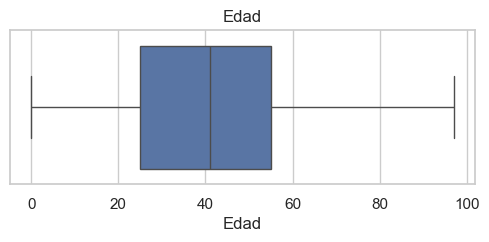

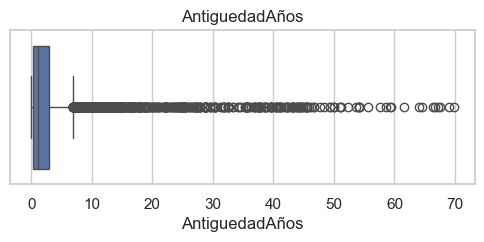

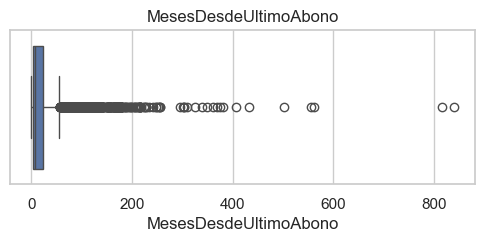

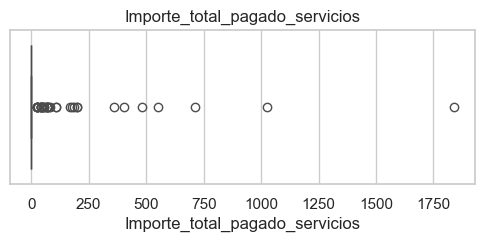

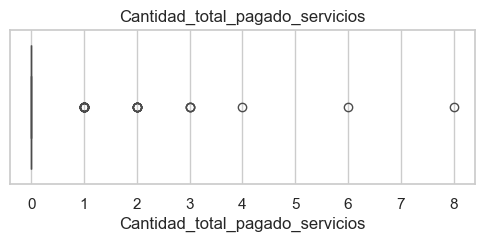

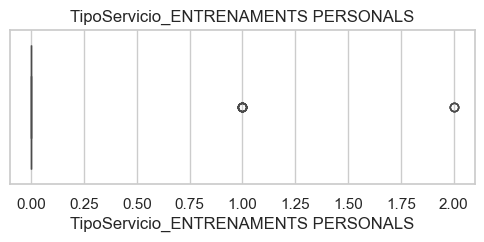

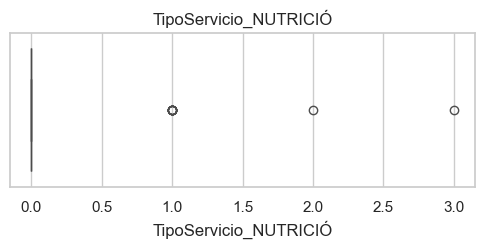

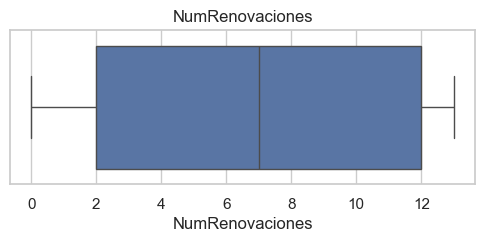

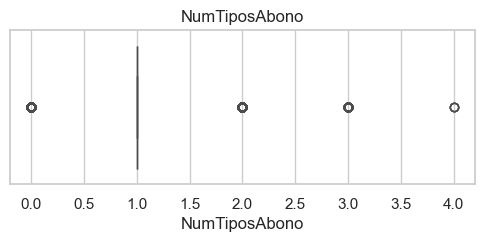

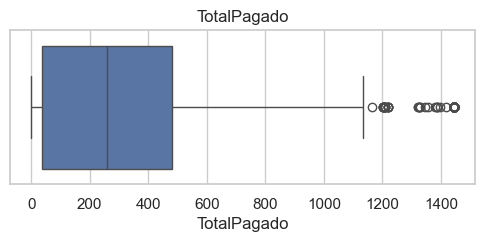

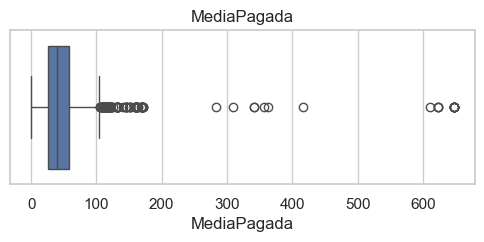

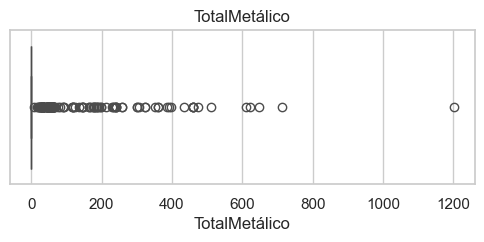

[('DeltaDuracionUlt90VsTotal', np.int64(3182)),
 ('MaxVisitasDia', np.int64(2911)),
 ('NumTiposAbono', np.int64(2040)),
 ('MesesDesdeUltimoPago', np.int64(1768)),
 ('VisitasFestivos', np.int64(1734)),
 ('PropVisitasFestivos', np.int64(1734)),
 ('TotalAbono_AA00', np.int64(1457)),
 ('TendenciaPago', np.int64(1391)),
 ('VisitasRed9a14', np.int64(1314)),
 ('PropVisitasRed9a14', np.int64(1314)),
 ('CefVarImporte', np.int64(1282)),
 ('VarDiasSemana', np.int64(1117)),
 ('FrecuenciaModal', np.int64(1046)),
 ('NumCambiosAbono', np.int64(994)),
 ('AntiguedadAños', np.int64(969)),
 ('TotalAbono_JO00', np.int64(926)),
 ('DiasDesdeUltima', np.int64(882)),
 ('MesesDesdeUltimoAbono', np.int64(851)),
 ('VarVisitasMes', np.int64(772)),
 ('TendenciaPagoMismoAbono', np.int64(753))]

In [34]:
# Boxplots para variables numéricas clave
for c in num_cols[:12]:
    plt.figure(figsize=(6,2))
    sns.boxplot(x=df[c].dropna()); plt.title(c); plt.show()

# Regla IQR para detectar extremos
def detect_outliers_iqr(series, k=1.5):
    q1 = series.quantile(0.25); q3 = series.quantile(0.75)
    iqr = q3-q1
    low = q1 - k*iqr; high = q3 + k*iqr
    return (series < low) | (series > high)

outlier_counts = {c: detect_outliers_iqr(df[c].dropna()).sum() if c in num_cols else 0 for c in num_cols}
sorted(outlier_counts.items(), key=lambda x: x[1], reverse=True)[:20]


## THE FINAL FEATURE ENGINEERING

## MODELAJE

In [44]:
# ==============================
# 1. LIBRERÍAS
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, accuracy_score, f1_score, recall_score,
    confusion_matrix, roc_curve, auc
)

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

## MODELO 1  (CON TOTAL PAGADO Y VIDAGYMMESES)

In [72]:
df_modelo = df.copy()

In [73]:
# ======================================
# 1. SEPARACIÓN BALANCEADA DEL 20% FINAL
# ======================================
 
def separacion_df_inferencia_test_final(df):
    # Separar por clase
    df_churn_0 = df[df['Abandono'] == 0]
    df_churn_1 = df[df['Abandono'] == 1]

    # Cantidad del 10% de cada clase
    n_10pct_0 = int(0.10 * len(df))
    n_10pct_1 = int(0.10 * len(df))

    # Sample aleatorio (sin reemplazo)
    valid_0 = df_churn_0.sample(n=n_10pct_0, random_state=42)
    valid_1 = df_churn_1.sample(n=n_10pct_1, random_state=42)

    # Concatenar para tener el 20% de validación balanceado
    df_validacion = pd.concat([valid_0, valid_1]).reset_index(drop=True)

    # # Crear conjunto de entrenamiento excluyendo los de validación
    df_train = df.drop(df_validacion.index).reset_index(drop=True)

    return df_validacion, df_train

In [74]:
df_validacion, df_train= separacion_df_inferencia_test_final(df_modelo)

In [75]:
X = df_train[['Edad', 'VidaGymMeses', 'Sexo_Mujer', 
        'UsoServiciosExtra',
        'ratio_cantidad_2025_2024',
        'Diversidad_servicios_extra',
        'TotalPagadoEconomia',
        'TotalVisitas',
        'DiasActivo',
        'VisitasUlt90',
        'VisitasUlt180',
        'TieneAccesos',
        'VisitasPrimerTrimestre', 'VisitasUltimoTrimestre', 'DiaFav_domingo',
       'DiaFav_jueves', 'DiaFav_lunes', 'DiaFav_martes', 'DiaFav_miércoles',
       'DiaFav_sábado', 'DiaFav_viernes', 'EstFav_invierno', 'EstFav_otono',
       'EstFav_primavera', 'EstFav_verano', 
        ]]

y = df_train['Abandono']

In [ ]:
def aplicacion_modelo(X, y):
    # ==============================
    # 2. SPLIT Y ESCALADO

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # ==============================
    # 3. MODELOS Y PARÁMETROS

    modelos = {
        "Regresión Logística": LogisticRegression(max_iter=1000, random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(random_state=42),
        "SVM": SVC(probability=True, random_state=42),
        "KNN": KNeighborsClassifier()
    }

    param_grids = {
        "Regresión Logística": {"C": [0.01, 0.1, 1, 10], "penalty": ["l2"], "solver": ["lbfgs"]},
        "Random Forest": {"n_estimators": [100, 200], "max_depth": [None, 5, 10],
                        "min_samples_split": [2, 5], "min_samples_leaf": [1, 2]},
        "Gradient Boosting": {"n_estimators": [100, 200], "learning_rate": [0.01, 0.05, 0.1],
                            "max_depth": [2, 3, 4], "subsample": [0.8, 1.0]},
        "SVM": {"C": [0.1, 1, 10], "kernel": ["rbf", "poly"], "gamma": ["scale", "auto"]},
        "KNN": {"n_neighbors": [3, 5, 7, 9], "weights": ["uniform", "distance"]}
    }

    # ==============================
    # 4. ENTRENAMIENTO Y EVALUACIÓN

    resultados = []

    plt.figure(figsize=(10, 8))

    for nombre, modelo in modelos.items():
        print(f"\n🔍 Optimizando {nombre}...")
        start = time.time()

        grid = GridSearchCV(
            estimator=modelo,
            param_grid=param_grids[nombre],
            scoring='roc_auc',
            cv=5,
            n_jobs=-1,
            verbose=0
        )
        grid.fit(X_train_scaled, y_train)
        tiempo = round(time.time() - start, 2)

        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test_scaled)
        y_prob = best_model.predict_proba(X_test_scaled)[:, 1] if hasattr(best_model, "predict_proba") else None

        # Métricas
        cm = confusion_matrix(y_test, y_pred)

        if y_prob is not None:
            fpr, tpr, thresholds = roc_curve(y_test, y_prob)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{nombre} (AUC = {roc_auc:.2f})')
        else:
            roc_auc = None

        resultados.append({
            "Modelo": nombre,
            "Mejores Parámetros": grid.best_params_,
            "AUC": roc_auc,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1": f1_score(y_test, y_pred),
            "Matriz Confusión": cm,
            "Tiempo (s)": tiempo,
            "Best_Model": best_model
        })

    # ==============================
    # 5. RESULTADOS EN DATAFRAME

    df_resultados = pd.DataFrame(resultados).sort_values(by="AUC", ascending=False)
    display(df_resultados)

    # ==============================
    # 6. CURVA ROC COMPARATIVA

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Curva ROC de modelos")
    plt.legend(loc="lower right")
    plt.show()

    # ==============================
    # 7. MEJOR MODELO

    mejor_modelo = df_resultados.iloc[0]
    best_model = mejor_modelo["Best_Model"]

    print("\n🏆 Mejor modelo:")
    print("Modelo:", mejor_modelo["Modelo"])
    print("AUC:", round(mejor_modelo["AUC"], 3))
    print("Accuracy:", round(mejor_modelo["Accuracy"], 3))
    print("Recall:", round(mejor_modelo["Recall"], 3))
    print("F1:", round(mejor_modelo["F1"], 3))
    print("Mejores Parámetros:", mejor_modelo["Mejores Parámetros"])
    print("Matriz de Confusión:\n", mejor_modelo["Matriz Confusión"])

    # ==============================
    # 8. IMPORTANCIA DE VARIABLES (si aplica)

    if hasattr(best_model, "feature_importances_"):
        importances = pd.DataFrame({
            'Variable': X_train.columns,
            'Importancia': best_model.feature_importances_
        }).sort_values(by='Importancia', ascending=False)

        print("\n🔥 Importancia de variables del mejor modelo:")
        display(importances)

        plt.figure(figsize=(10, 6))
        plt.barh(importances['Variable'], importances['Importancia'])
        plt.gca().invert_yaxis()
        plt.title(f"Top variables - {mejor_modelo['Modelo']}")
        plt.show()
    else:
        print("\n⚠️ Este modelo no tiene atributo 'feature_importances_'")
    
    return best_model, scaler


🔍 Optimizando Regresión Logística...

🔍 Optimizando Random Forest...

🔍 Optimizando Gradient Boosting...

🔍 Optimizando SVM...

🔍 Optimizando KNN...


,Modelo,Mejores Parámetros,AUC,Accuracy,Recall,F1,Matriz Confusión,Tiempo (s),Best_Model
2,Gradient Boosting,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",0.978878,0.934175,0.888224,0.924195,"[[591, 17], [56, 445]]",26.11,([DecisionTreeRegressor(criterion='friedman_ms...
1,Random Forest,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.972543,0.915239,0.854291,0.901053,"[[587, 21], [73, 428]]",10.58,"(DecisionTreeClassifier(max_features='sqrt', r..."
3,SVM,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.951098,0.904418,0.862275,0.890722,"[[571, 37], [69, 432]]",15.19,"SVC(C=10, probability=True, random_state=42)"
0,Regresión Logística,"{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}",0.941111,0.885482,0.860279,0.871587,"[[551, 57], [70, 431]]",0.16,"LogisticRegression(C=1, max_iter=1000, random_..."
4,KNN,"{'n_neighbors': 9, 'weights': 'distance'}",0.934590,0.875564,0.836327,0.858607,"[[552, 56], [82, 419]]",0.18,"KNeighborsClassifier(n_neighbors=9, weights='d..."


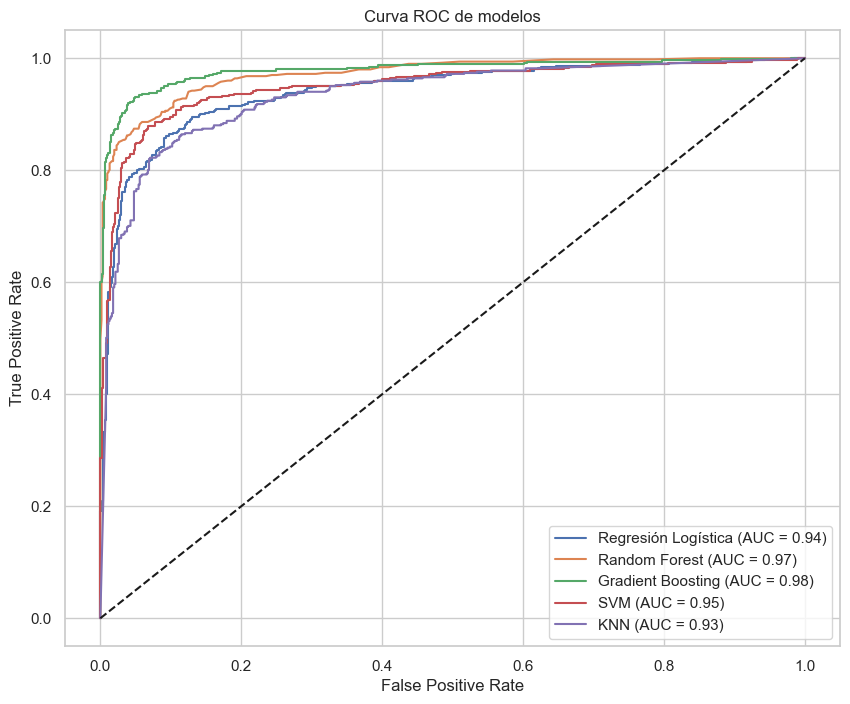


🏆 Mejor modelo:
Modelo: Gradient Boosting
AUC: 0.979
Accuracy: 0.934
Recall: 0.888
F1: 0.924
Mejores Parámetros: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.8}
Matriz de Confusión:
 [[591  17]
 [ 56 445]]

🔥 Importancia de variables del mejor modelo:


,Variable,Importancia
6,TotalPagadoEconomia,0.687337
1,VidaGymMeses,0.173514
0,Edad,0.046952
7,TotalVisitas,0.020347
24,EstFav_verano,0.020059
8,DiasActivo,0.014266
23,EstFav_primavera,0.007469
10,VisitasUlt180,0.007013
22,EstFav_otono,0.006926
13,VisitasUltimoTrimestre,0.004036


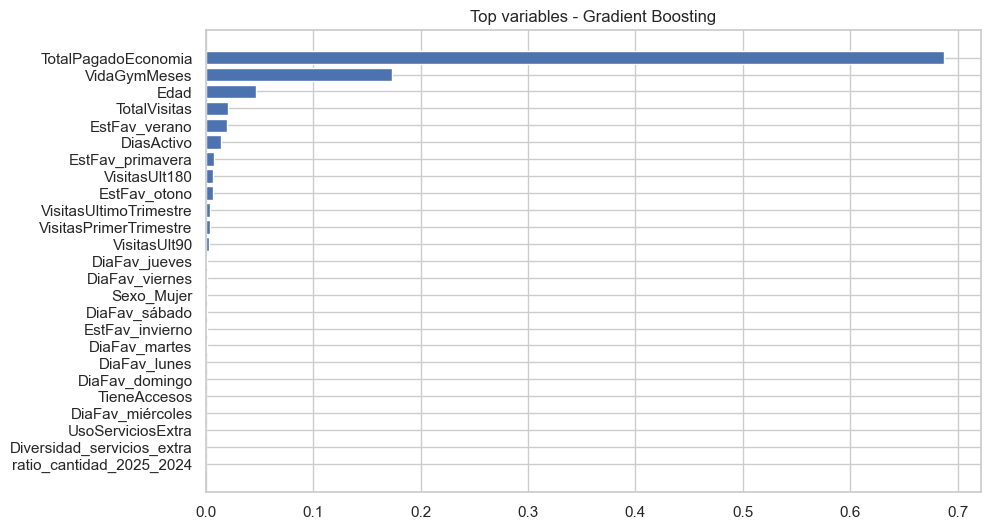

In [77]:
best_model, scaler= aplicacion_modelo(X, y)

In [78]:
def validacion_inferencia_testfinal(X, scaler, best_model, df_validacion):
       # A: Esto debería funcionar
    try:
        X_val = df_validacion[X.columns]
    except Exception as e:
        print("Error al crear X_val:", e)
        return None

    # B: Esto también
    try:
        y_val = df_validacion['Abandono']
    except Exception as e:
        print("Error al crear y_val:", e)
        return None

    # C: Escalado
    try:
        X_val_scaled = scaler.transform(X_val)
    except Exception as e:
        print("Error al escalar:", e)
        return None

    # D: Predicción
    try:
        y_val_pred = best_model.predict(X_val_scaled)
        y_val_prob = best_model.predict_proba(X_val_scaled)[:, 1]
     
    except Exception as e:
        print("Error al predecir:", e)
        return None

    # E: Métricas
    try:
        print("Accuracy:", accuracy_score(y_val, y_val_pred))
        print("Recall:", recall_score(y_val, y_val_pred))
        print("F1 Score:", f1_score(y_val, y_val_pred))
        print("Matriz de Confusión:\n", confusion_matrix(y_val, y_val_pred))

        fpr_val, tpr_val, _ = roc_curve(y_val, y_val_prob)
        roc_auc_val = auc(fpr_val, tpr_val)
        print("AUC (Inferencia Test):", round(roc_auc_val, 3))

        plt.plot(fpr_val, tpr_val, label=f'ROC (AUC = {roc_auc_val:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.title("Curva ROC - Inferencia Test final")
        plt.legend()
        plt.show()
    except Exception as e:
        print("Error en métricas o plot:", e)
        return None

    return y_val_prob


In [79]:
df_validacion_modelo1= df_validacion.copy()

Accuracy: 0.8179190751445087
Recall: 0.9653179190751445
F1 Score: 0.8413098236775819
Matriz de Confusión:
 [[464 228]
 [ 24 668]]
AUC (Inferencia Test): 0.815


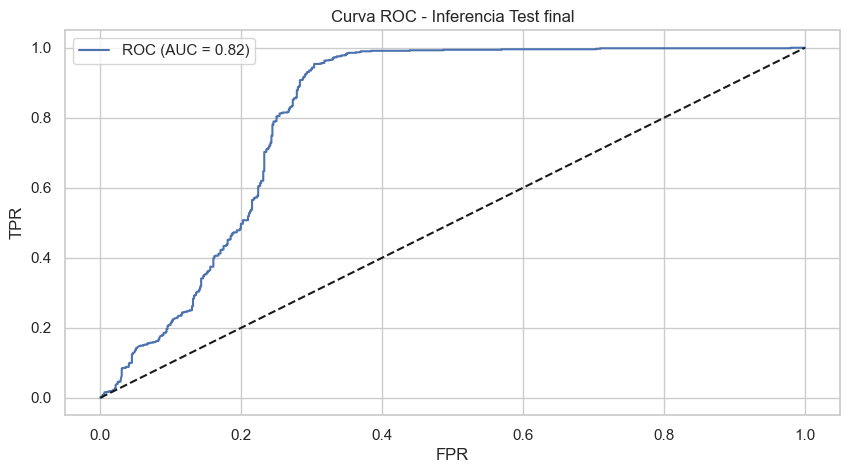

In [80]:
y_val_prob= validacion_inferencia_testfinal(X, scaler, best_model, df_validacion_modelo1)

In [58]:
def clasificar_riesgo(df_validation, y_val_prob):
    # Añadir columna de probabilidad de abandono
    df_validation["Prob_Abandono"] = y_val_prob

    # Crear niveles de riesgo
    df_validation["Nivel_Riesgo"] = pd.cut(df_validation["Prob_Abandono"], bins=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
        labels=["Muy Bajo", "Bajo", "Medio", "Alto", "Muy Alto"],  include_lowest=True)
    return df_validation

In [81]:
df_validacion_modelo1= clasificar_riesgo(df_validacion_modelo1, y_val_prob)
df_validacion_modelo1

,IdPersona,Edad,FechaInscripcion,TipoAbonoActual,Sexo_Mujer,FAntiguedad,NumAltasAntesDelPeriodo,TuvoAltasPrevias,MesesDesdeUltimaAltaPrevia,MesesDuracionAbonoActual,...,DiaFav_miércoles,DiaFav_sábado,DiaFav_viernes,EstFav_invierno,EstFav_otono,EstFav_primavera,EstFav_verano,TieneAccesos,Prob_Abandono,Nivel_Riesgo
0,104911,21,2025-04-01,JO00,True,2025-01-02,0.0,False,-1.0,5.0,...,False,False,False,False,False,True,False,True,0.958356,Muy Alto
1,105737,46,2024-02-01,AA00,False,2021-01-30,1.0,True,7.0,19.0,...,False,False,False,False,False,False,True,True,0.005571,Muy Bajo
2,25240,43,2021-02-01,AR00,True,2000-07-07,2.0,True,43.0,55.0,...,False,False,False,False,False,False,True,True,0.017786,Muy Bajo
3,116352,44,2025-05-01,MA00,True,2025-04-05,0.0,False,-1.0,4.0,...,False,False,False,False,False,False,True,True,0.996124,Muy Alto
4,115558,24,2024-11-08,JO00,True,2024-11-08,0.0,False,-1.0,9.0,...,False,False,False,True,False,False,False,True,0.101703,Muy Bajo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1379,103700,44,2024-08-06,AA00,True,2024-08-06,-1.0,False,-1.0,-1.0,...,False,False,False,False,False,False,False,False,0.998051,Muy Alto
1380,107740,41,2024-11-01,AC00,False,2024-09-03,-1.0,False,-1.0,-1.0,...,False,False,False,False,True,False,False,True,0.823322,Muy Alto
1381,91606,30,2023-04-01,AA00,False,2023-02-27,-1.0,False,-1.0,-1.0,...,False,False,False,False,True,False,False,True,0.992455,Muy Alto
1382,115688,32,2025-01-01,AF00,False,2024-12-03,-1.0,False,-1.0,-1.0,...,False,True,False,True,False,False,False,True,0.997398,Muy Alto


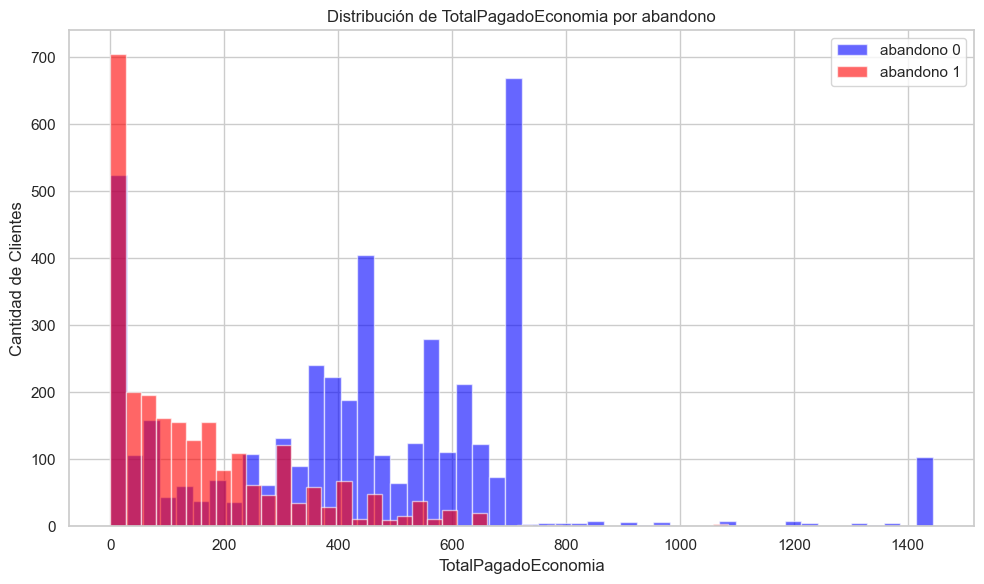

In [82]:
# Filtrar los datos por cada categoría de Abandono
abandono_0 = df_modelo[df_modelo['Abandono'] == 0]['TotalPagadoEconomia']
abandono_1 = df_modelo[df_modelo['Abandono'] == 1]['TotalPagadoEconomia']

# Crear el histograma en un solo gráfico
plt.figure(figsize=(10, 6))

plt.hist(abandono_0, bins=50, alpha=0.6, label='abandono 0', color='blue')
plt.hist(abandono_1, bins=50, alpha=0.6, label='abandono 1', color='red')

plt.xlabel('TotalPagadoEconomia')
plt.ylabel('Cantidad de Clientes')
plt.title('Distribución de TotalPagadoEconomia por abandono')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## MODELO 2 (CON VIDAGYMMESES Y SIN TOTAL PAGADO)

In [83]:
X_2 = df_train[['Edad', 'VidaGymMeses', 'Sexo_Mujer', 
        'UsoServiciosExtra',
        'ratio_cantidad_2025_2024',
        'Diversidad_servicios_extra',
        #'TotalPagadoEconomia',
        'TotalVisitas',
        'DiasActivo',
        'VisitasUlt90',
        'VisitasUlt180',
        'TieneAccesos',
        'VisitasPrimerTrimestre', 'VisitasUltimoTrimestre', 'DiaFav_domingo',
       'DiaFav_jueves', 'DiaFav_lunes', 'DiaFav_martes', 'DiaFav_miércoles',
       'DiaFav_sábado', 'DiaFav_viernes', 'EstFav_invierno', 'EstFav_otono',
       'EstFav_primavera', 'EstFav_verano', 
        ]]

y_2= df_train['Abandono']



🔍 Optimizando Regresión Logística...

🔍 Optimizando Random Forest...

🔍 Optimizando Gradient Boosting...

🔍 Optimizando SVM...

🔍 Optimizando KNN...


,Modelo,Mejores Parámetros,AUC,Accuracy,Recall,F1,Matriz Confusión,Tiempo (s),Best_Model
2,Gradient Boosting,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",0.950901,0.879170,0.822355,0.860125,"[[563, 45], [89, 412]]",22.60,([DecisionTreeRegressor(criterion='friedman_ms...
1,Random Forest,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.943124,0.868350,0.800399,0.845992,"[[562, 46], [100, 401]]",9.05,"(DecisionTreeClassifier(max_depth=10, max_feat..."
3,SVM,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.934038,0.863841,0.854291,0.850050,"[[530, 78], [73, 428]]",19.47,"SVC(C=10, probability=True, random_state=42)"
0,Regresión Logística,"{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}",0.919043,0.850316,0.852295,0.837255,"[[516, 92], [74, 427]]",0.16,"LogisticRegression(C=1, max_iter=1000, random_..."
4,KNN,"{'n_neighbors': 9, 'weights': 'distance'}",0.882515,0.805230,0.786427,0.784861,"[[499, 109], [107, 394]]",0.21,"KNeighborsClassifier(n_neighbors=9, weights='d..."


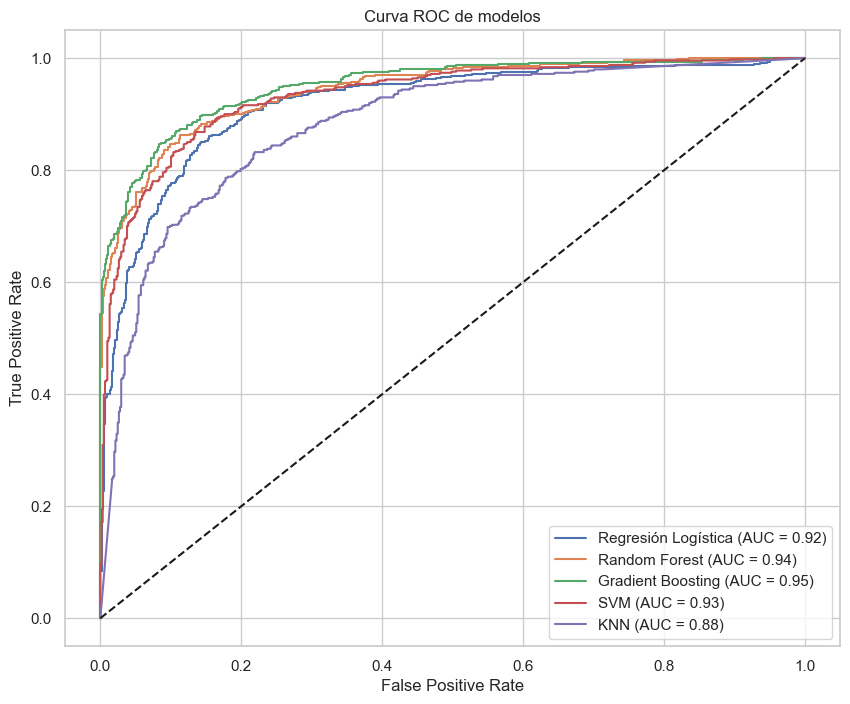


🏆 Mejor modelo:
Modelo: Gradient Boosting
AUC: 0.951
Accuracy: 0.879
Recall: 0.822
F1: 0.86
Mejores Parámetros: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.8}
Matriz de Confusión:
 [[563  45]
 [ 89 412]]

🔥 Importancia de variables del mejor modelo:


,Variable,Importancia
1,VidaGymMeses,0.607645
6,TotalVisitas,0.092388
7,DiasActivo,0.065534
0,Edad,0.048726
23,EstFav_verano,0.036401
9,VisitasUlt180,0.035015
21,EstFav_otono,0.028876
11,VisitasPrimerTrimestre,0.019397
8,VisitasUlt90,0.017430
12,VisitasUltimoTrimestre,0.014988


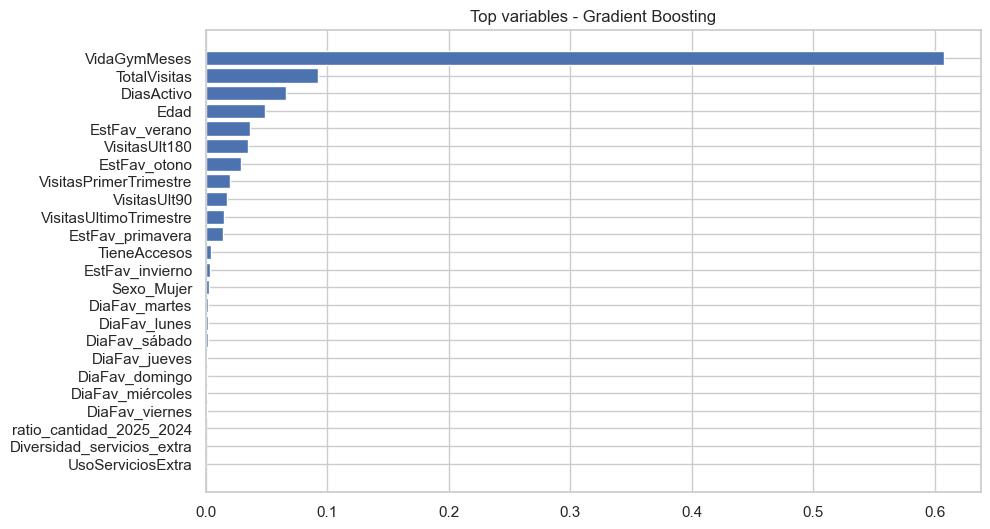

In [84]:
best_model, scaler= aplicacion_modelo(X_2, y_2)

In [85]:
df_validacion_modelo2= df_validacion.copy()

Accuracy: 0.7817919075144508
Recall: 0.9219653179190751
F1 Score: 0.8086185044359949
Matriz de Confusión:
 [[444 248]
 [ 54 638]]
AUC (Inferencia Test): 0.765


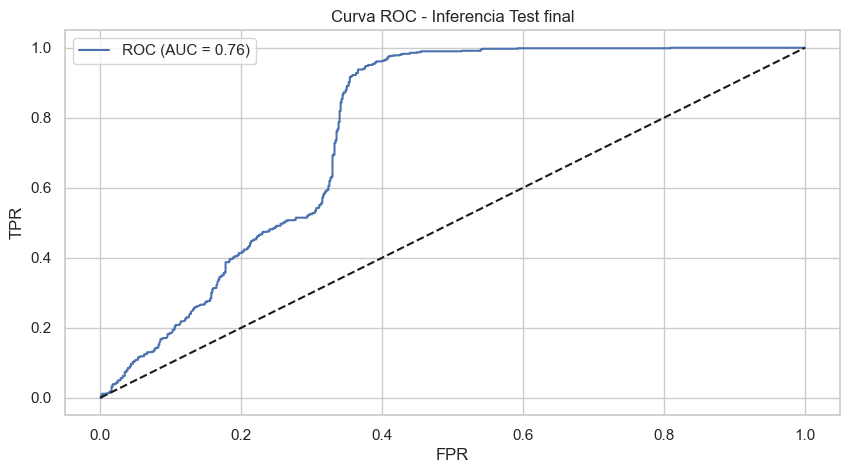

In [86]:
y_val_prob_2= validacion_inferencia_testfinal(X_2, scaler, best_model, df_validacion_modelo2)

In [87]:
df_validacion_modelo2= clasificar_riesgo(df_validacion_modelo2, y_val_prob_2)
df_validacion_modelo2

,IdPersona,Edad,FechaInscripcion,TipoAbonoActual,Sexo_Mujer,FAntiguedad,NumAltasAntesDelPeriodo,TuvoAltasPrevias,MesesDesdeUltimaAltaPrevia,MesesDuracionAbonoActual,...,DiaFav_miércoles,DiaFav_sábado,DiaFav_viernes,EstFav_invierno,EstFav_otono,EstFav_primavera,EstFav_verano,TieneAccesos,Prob_Abandono,Nivel_Riesgo
0,104911,21,2025-04-01,JO00,True,2025-01-02,0.0,False,-1.0,5.0,...,False,False,False,False,False,True,False,True,0.925160,Muy Alto
1,105737,46,2024-02-01,AA00,False,2021-01-30,1.0,True,7.0,19.0,...,False,False,False,False,False,False,True,True,0.026323,Muy Bajo
2,25240,43,2021-02-01,AR00,True,2000-07-07,2.0,True,43.0,55.0,...,False,False,False,False,False,False,True,True,0.005634,Muy Bajo
3,116352,44,2025-05-01,MA00,True,2025-04-05,0.0,False,-1.0,4.0,...,False,False,False,False,False,False,True,True,0.992328,Muy Alto
4,115558,24,2024-11-08,JO00,True,2024-11-08,0.0,False,-1.0,9.0,...,False,False,False,True,False,False,False,True,0.160875,Muy Bajo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1379,103700,44,2024-08-06,AA00,True,2024-08-06,-1.0,False,-1.0,-1.0,...,False,False,False,False,False,False,False,False,0.996952,Muy Alto
1380,107740,41,2024-11-01,AC00,False,2024-09-03,-1.0,False,-1.0,-1.0,...,False,False,False,False,True,False,False,True,0.885964,Muy Alto
1381,91606,30,2023-04-01,AA00,False,2023-02-27,-1.0,False,-1.0,-1.0,...,False,False,False,False,True,False,False,True,0.944132,Muy Alto
1382,115688,32,2025-01-01,AF00,False,2024-12-03,-1.0,False,-1.0,-1.0,...,False,True,False,True,False,False,False,True,0.994717,Muy Alto


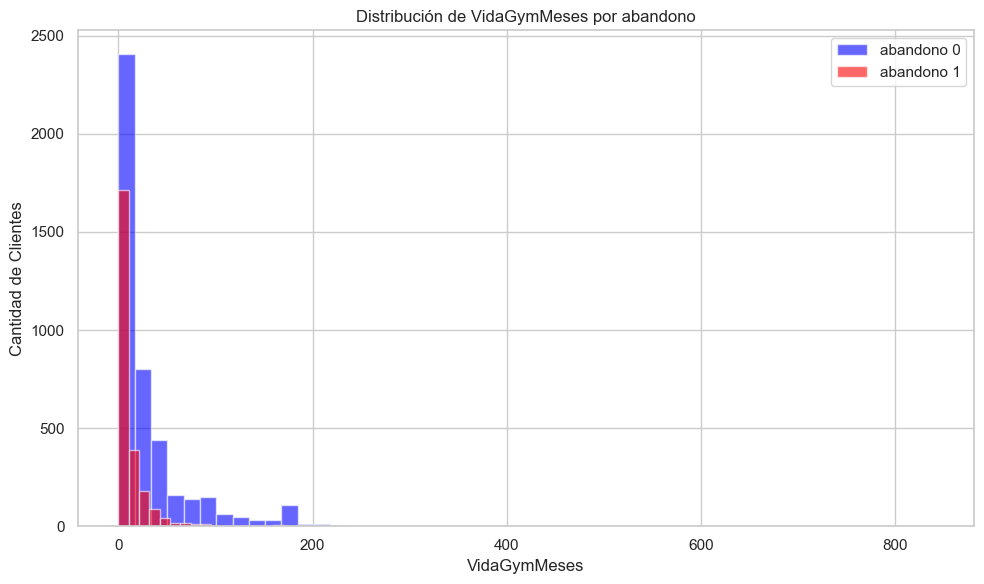

In [89]:
# Filtrar los datos por cada categoría de Abandono
abandono_0 = df_modelo[df_modelo['Abandono'] == 0]['VidaGymMeses']
abandono_1 = df_modelo[df_modelo['Abandono'] == 1]['VidaGymMeses']

# Crear el histograma en un solo gráfico
plt.figure(figsize=(10, 6))

plt.hist(abandono_0, bins=50, alpha=0.6, label='abandono 0', color='blue')
plt.hist(abandono_1, bins=50, alpha=0.6, label='abandono 1', color='red')

plt.xlabel('VidaGymMeses')
plt.ylabel('Cantidad de Clientes')
plt.title('Distribución de VidaGymMeses por abandono')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## MODELO 3 (SIN VIDAGYMMESES Y SIN TOTAL PAGADO)

In [91]:
# ===============================
# 2. SPLIT NORMAL EN TRAIN / TEST
# ===============================

# Separar variables y target
X_3 = df_train[[
    'Edad',
    'Sexo_Mujer', 'UsoServiciosExtra',
    'ratio_cantidad_2025_2024', 'Diversidad_servicios_extra',
    'TotalVisitas', 'DiasActivo', 'VisitasUlt90', 'VisitasUlt180',
    'TieneAccesos', 'VisitasPrimerTrimestre', 'VisitasUltimoTrimestre',
    'DiaFav_domingo', 'DiaFav_jueves', 'DiaFav_lunes', 'DiaFav_martes',
    'DiaFav_miércoles', 'DiaFav_sábado', 'DiaFav_viernes',
    'EstFav_invierno', 'EstFav_otono', 'EstFav_primavera', 'EstFav_verano'
]]
y_3 = df_train['Abandono']




🔍 Optimizando Regresión Logística...

🔍 Optimizando Random Forest...

🔍 Optimizando Gradient Boosting...

🔍 Optimizando SVM...

🔍 Optimizando KNN...


,Modelo,Mejores Parámetros,AUC,Accuracy,Recall,F1,Matriz Confusión,Tiempo (s),Best_Model
2,Gradient Boosting,"{'learning_rate': 0.05, 'max_depth': 4, 'n_est...",0.906163,0.829576,0.800399,0.809284,"[[519, 89], [100, 401]]",22.72,([DecisionTreeRegressor(criterion='friedman_ms...
3,SVM,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.904935,0.838593,0.844311,0.825366,"[[507, 101], [78, 423]]",23.00,"SVC(C=10, probability=True, random_state=42)"
1,Random Forest,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.902041,0.827773,0.790419,0.805697,"[[522, 86], [105, 396]]",8.78,"(DecisionTreeClassifier(max_depth=10, max_feat..."
0,Regresión Logística,"{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}",0.897764,0.820559,0.814371,0.803941,"[[502, 106], [93, 408]]",0.15,"LogisticRegression(C=10, max_iter=1000, random..."
4,KNN,"{'n_neighbors': 9, 'weights': 'distance'}",0.848128,0.787196,0.734531,0.757202,"[[505, 103], [133, 368]]",0.20,"KNeighborsClassifier(n_neighbors=9, weights='d..."


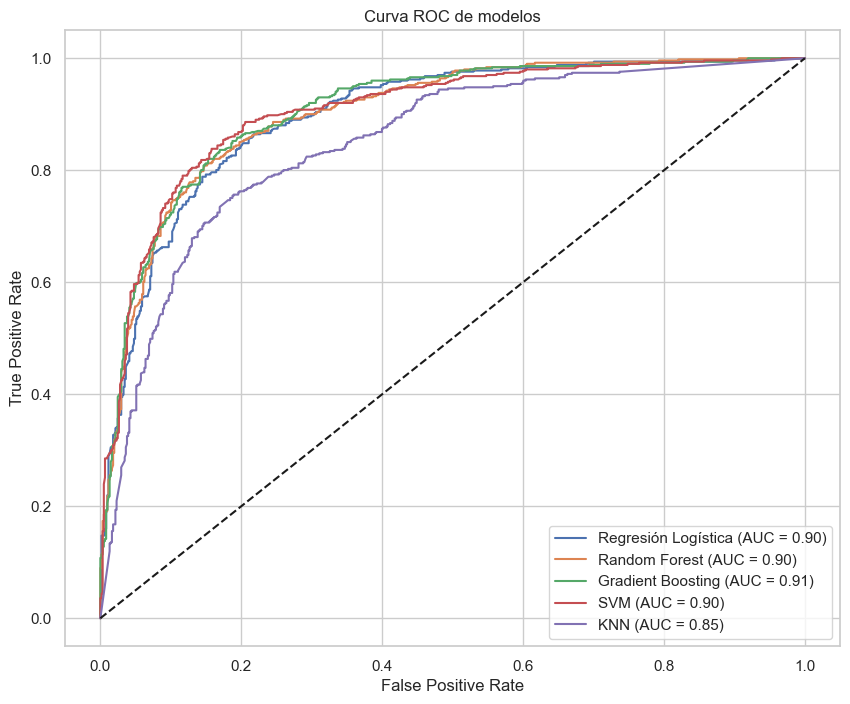


🏆 Mejor modelo:
Modelo: Gradient Boosting
AUC: 0.906
Accuracy: 0.83
Recall: 0.8
F1: 0.809
Mejores Parámetros: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.8}
Matriz de Confusión:
 [[519  89]
 [100 401]]

🔥 Importancia de variables del mejor modelo:


,Variable,Importancia
6,DiasActivo,0.321370
5,TotalVisitas,0.204689
0,Edad,0.144177
10,VisitasPrimerTrimestre,0.124609
8,VisitasUlt180,0.063792
7,VisitasUlt90,0.044818
11,VisitasUltimoTrimestre,0.037064
20,EstFav_otono,0.019148
22,EstFav_verano,0.013781
1,Sexo_Mujer,0.004063


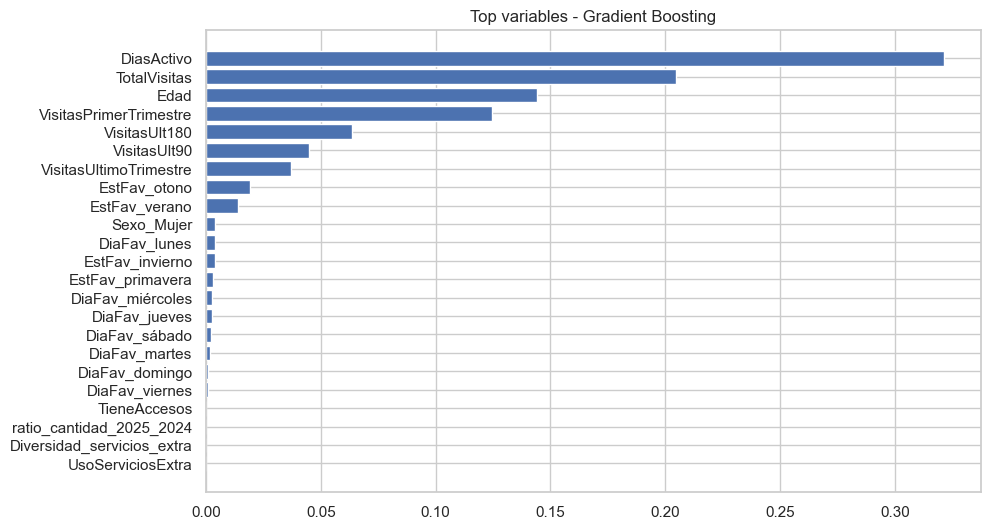

In [93]:
best_model, scaler= aplicacion_modelo(X_3, y_3)

In [113]:
df_validacion_modelo3=  df_validacion.copy()

Accuracy: 0.7882947976878613
Recall: 0.8554913294797688
F1 Score: 0.8016249153689912
Matriz de Confusión:
 [[499 193]
 [100 592]]
AUC (Inferencia Test): 0.855


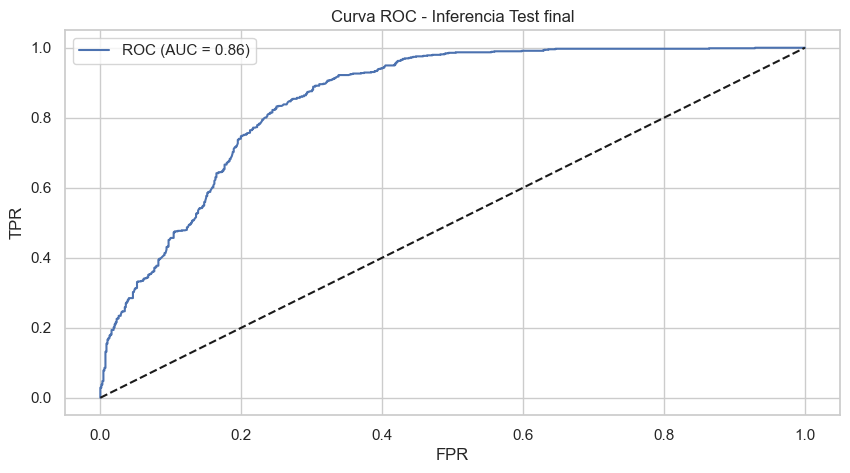

In [114]:
y_val_prob_3= validacion_inferencia_testfinal(X_3, scaler, best_model, df_validacion_modelo3)


In [115]:
df_validacion_modelo3= clasificar_riesgo(df_validacion_modelo3, y_val_prob_3)
df_validacion_modelo3

,IdPersona,Edad,FechaInscripcion,TipoAbonoActual,Sexo_Mujer,FAntiguedad,NumAltasAntesDelPeriodo,TuvoAltasPrevias,MesesDesdeUltimaAltaPrevia,MesesDuracionAbonoActual,...,DiaFav_miércoles,DiaFav_sábado,DiaFav_viernes,EstFav_invierno,EstFav_otono,EstFav_primavera,EstFav_verano,TieneAccesos,Prob_Abandono,Nivel_Riesgo
0,104911,21,2025-04-01,JO00,True,2025-01-02,0.0,False,-1.0,5.0,...,False,False,False,False,False,True,False,True,0.063284,Muy Bajo
1,105737,46,2024-02-01,AA00,False,2021-01-30,1.0,True,7.0,19.0,...,False,False,False,False,False,False,True,True,0.029924,Muy Bajo
2,25240,43,2021-02-01,AR00,True,2000-07-07,2.0,True,43.0,55.0,...,False,False,False,False,False,False,True,True,0.014685,Muy Bajo
3,116352,44,2025-05-01,MA00,True,2025-04-05,0.0,False,-1.0,4.0,...,False,False,False,False,False,False,True,True,0.508281,Medio
4,115558,24,2024-11-08,JO00,True,2024-11-08,0.0,False,-1.0,9.0,...,False,False,False,True,False,False,False,True,0.070744,Muy Bajo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1379,103700,44,2024-08-06,AA00,True,2024-08-06,-1.0,False,-1.0,-1.0,...,False,False,False,False,False,False,False,False,0.774336,Alto
1380,107740,41,2024-11-01,AC00,False,2024-09-03,-1.0,False,-1.0,-1.0,...,False,False,False,False,True,False,False,True,0.906310,Muy Alto
1381,91606,30,2023-04-01,AA00,False,2023-02-27,-1.0,False,-1.0,-1.0,...,False,False,False,False,True,False,False,True,0.948320,Muy Alto
1382,115688,32,2025-01-01,AF00,False,2024-12-03,-1.0,False,-1.0,-1.0,...,False,True,False,True,False,False,False,True,0.944436,Muy Alto


## INTERPRETACIÓN ÚLTIMO MODELO ELEGIDO

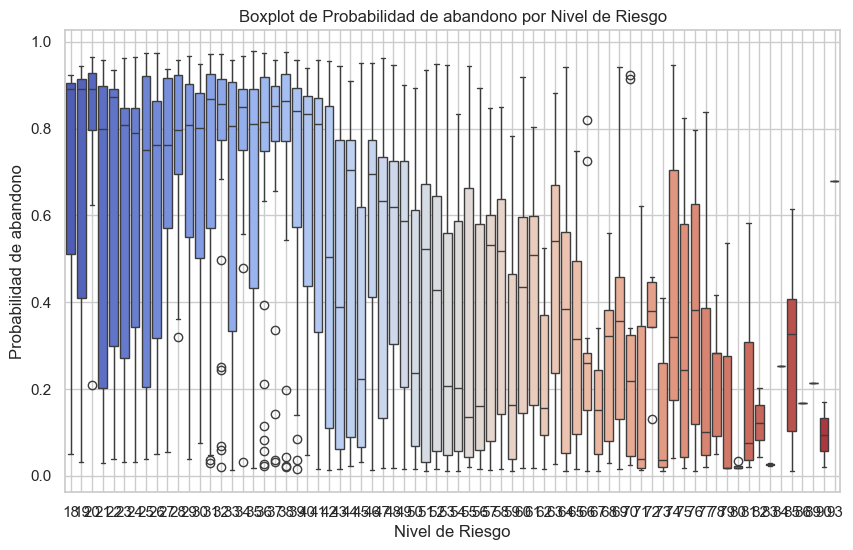

In [98]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="Edad", y="Prob_Abandono", data=df_validacion_modelo3, palette="coolwarm")
plt.title("Boxplot de Probabilidad de abandono por Nivel de Riesgo")
plt.xlabel("Nivel de Riesgo")
plt.ylabel("Probabilidad de abandono")
plt.grid(True)
plt.show()

In [116]:
# Crear grupos de edad
df_validacion_modelo3["GrupoEdad"] = pd.cut(
    df_validacion_modelo3["Edad"],
    bins=[18, 25, 35, 45, 55, 65, 80, df_validacion_modelo3["Edad"].max()],
    labels=["18–25", "26–35", "36–45", "46–55", "56–65", "66–80", "80+"],
    include_lowest=True
)

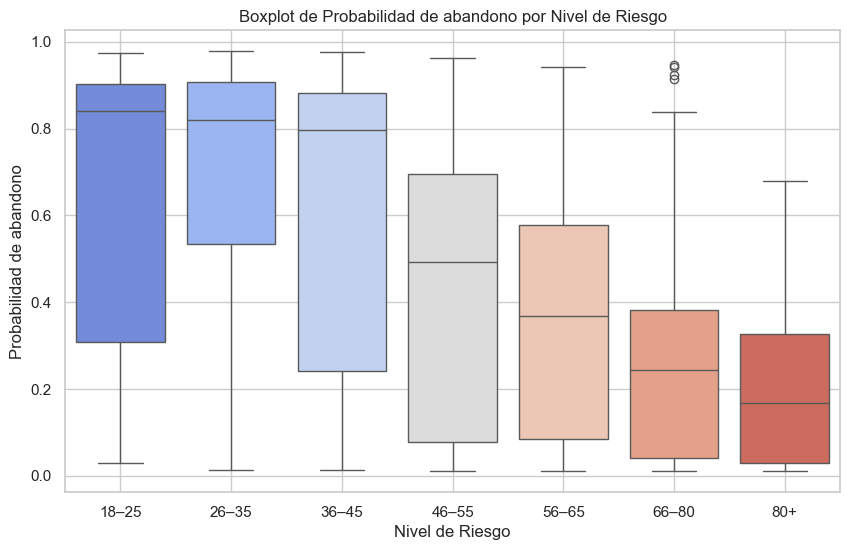

In [117]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="GrupoEdad", y="Prob_Abandono", data=df_validacion_modelo3, palette="coolwarm")
plt.title("Boxplot de Probabilidad de abandono por Nivel de Riesgo")
plt.xlabel("Nivel de Riesgo")
plt.ylabel("Probabilidad de abandono")
plt.grid(True)
plt.show()

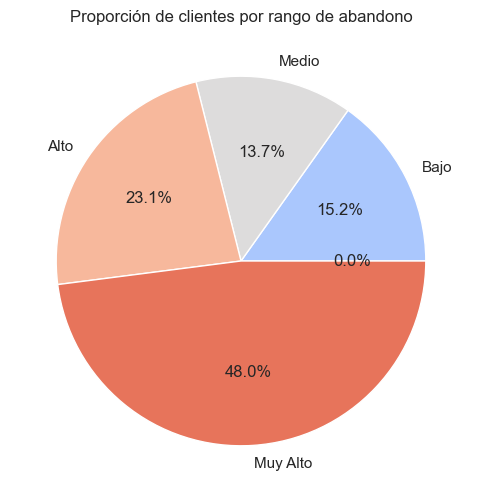

In [118]:
df_validacion_modelo3["Nivel_Riesgo"].value_counts().reindex(["Muy bajo","Bajo","Medio","Alto","Muy Alto"]).plot(
    kind="pie", autopct="%1.1f%%", figsize=(6,6), colors=sns.color_palette("coolwarm", 5)
)
plt.ylabel("")
plt.title("Proporción de clientes por rango de abandono")
plt.show()

In [119]:
df_validacion_modelo3[['IdPersona', 'Abandono', 'Prob_Abandono', 'Nivel_Riesgo']]

,IdPersona,Abandono,Prob_Abandono,Nivel_Riesgo
0,104911,0,0.063284,Muy Bajo
1,105737,0,0.029924,Muy Bajo
2,25240,0,0.014685,Muy Bajo
3,116352,0,0.508281,Medio
4,115558,0,0.070744,Muy Bajo
...,...,...,...,...
1379,103700,1,0.774336,Alto
1380,107740,1,0.906310,Muy Alto
1381,91606,1,0.948320,Muy Alto
1382,115688,1,0.944436,Muy Alto


In [123]:
activos= df_validacion_modelo3[df_validacion_modelo3['Abandono']==0]
activos

,IdPersona,Edad,FechaInscripcion,TipoAbonoActual,Sexo_Mujer,FAntiguedad,NumAltasAntesDelPeriodo,TuvoAltasPrevias,MesesDesdeUltimaAltaPrevia,MesesDuracionAbonoActual,...,DiaFav_sábado,DiaFav_viernes,EstFav_invierno,EstFav_otono,EstFav_primavera,EstFav_verano,TieneAccesos,Prob_Abandono,Nivel_Riesgo,GrupoEdad
0,104911,21,2025-04-01,JO00,True,2025-01-02,0.0,False,-1.0,5.0,...,False,False,False,False,True,False,True,0.063284,Muy Bajo,18–25
1,105737,46,2024-02-01,AA00,False,2021-01-30,1.0,True,7.0,19.0,...,False,False,False,False,False,True,True,0.029924,Muy Bajo,46–55
2,25240,43,2021-02-01,AR00,True,2000-07-07,2.0,True,43.0,55.0,...,False,False,False,False,False,True,True,0.014685,Muy Bajo,36–45
3,116352,44,2025-05-01,MA00,True,2025-04-05,0.0,False,-1.0,4.0,...,False,False,False,False,False,True,True,0.508281,Medio,36–45
4,115558,24,2024-11-08,JO00,True,2024-11-08,0.0,False,-1.0,9.0,...,False,False,True,False,False,False,True,0.070744,Muy Bajo,18–25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,114048,23,2024-05-28,JO00,True,2024-05-28,1.0,True,3.0,15.0,...,False,False,False,False,False,True,True,0.046488,Muy Bajo,18–25
688,28771,54,2024-02-26,AA00,True,2024-02-26,1.0,True,6.0,18.0,...,False,False,False,False,False,False,False,0.585807,Medio,46–55
689,92245,63,2011-09-08,AA00,True,2011-09-08,1.0,True,158.0,170.0,...,False,False,False,False,False,True,True,0.104051,Muy Bajo,56–65
690,99770,54,2024-03-01,AA00,False,2017-11-27,2.0,True,6.0,18.0,...,False,False,False,False,True,False,True,0.038816,Muy Bajo,46–55


In [125]:
activos[['IdPersona', 'Abandono', 'Prob_Abandono', 'Nivel_Riesgo']]

,IdPersona,Abandono,Prob_Abandono,Nivel_Riesgo
0,104911,0,0.063284,Muy Bajo
1,105737,0,0.029924,Muy Bajo
2,25240,0,0.014685,Muy Bajo
3,116352,0,0.508281,Medio
4,115558,0,0.070744,Muy Bajo
...,...,...,...,...
687,114048,0,0.046488,Muy Bajo
688,28771,0,0.585807,Medio
689,92245,0,0.104051,Muy Bajo
690,99770,0,0.038816,Muy Bajo


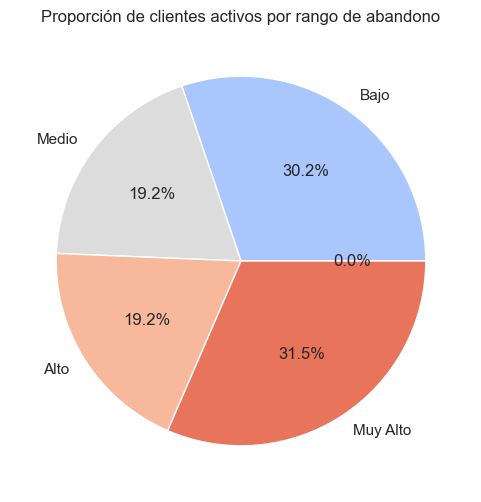

In [128]:
activos["Nivel_Riesgo"].value_counts().reindex(["Muy bajo","Bajo","Medio","Alto","Muy Alto"]).plot(
    kind="pie", autopct="%1.1f%%", figsize=(6,6), colors=sns.color_palette("coolwarm", 5)
)
plt.ylabel("")
plt.title("Proporción de clientes activos por rango de abandono")
plt.show()

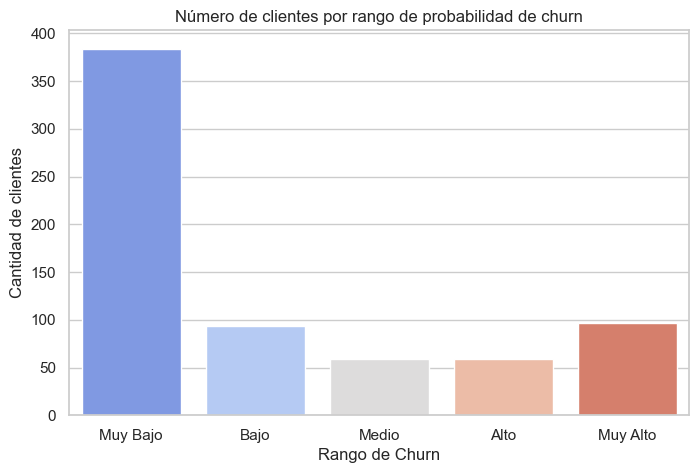

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración estética
sns.set_style("whitegrid")

# Conteo de clientes por rango
plt.figure(figsize=(8,5))
sns.countplot(x="Nivel_Riesgo", data=activos, order=["Muy Bajo","Bajo","Medio","Alto","Muy Alto"], palette="coolwarm")
plt.title("Número de clientes por rango de probabilidad de churn")
plt.xlabel("Rango de Churn")
plt.ylabel("Cantidad de clientes")
plt.show()

In [133]:
# Estadísticas básicas de churn real y predicho por nivel de riesgo
resumen_riesgo = activos.groupby('Nivel_Riesgo').agg(
    Cantidad=('IdPersona','count'),
    Churn_Real_Promedio=('Abandono','mean'),
    Churn_Predicho_Promedio=('Prob_Abandono','mean'),
    Prob_Churn_Promedio=('Prob_Abandono','mean')
).reset_index()

display(resumen_riesgo)

,Nivel_Riesgo,Cantidad,Churn_Real_Promedio,Churn_Predicho_Promedio,Prob_Churn_Promedio
0,Muy Bajo,384,0.0,0.066752,0.066752
1,Bajo,93,0.0,0.296654,0.296654
2,Medio,59,0.0,0.514531,0.514531
3,Alto,59,0.0,0.704433,0.704433
4,Muy Alto,97,0.0,0.870843,0.870843


In [124]:
no_activos= df_validacion_modelo3[df_validacion_modelo3['Abandono']==1]
no_activos


,IdPersona,Edad,FechaInscripcion,TipoAbonoActual,Sexo_Mujer,FAntiguedad,NumAltasAntesDelPeriodo,TuvoAltasPrevias,MesesDesdeUltimaAltaPrevia,MesesDuracionAbonoActual,...,DiaFav_sábado,DiaFav_viernes,EstFav_invierno,EstFav_otono,EstFav_primavera,EstFav_verano,TieneAccesos,Prob_Abandono,Nivel_Riesgo,GrupoEdad
692,115137,47,2024-09-03,AA00,True,2024-09-03,-1.0,False,-1.0,-1.0,...,False,False,False,True,False,False,True,0.962602,Muy Alto,46–55
693,94786,18,2024-07-26,FA00,False,2024-07-26,-1.0,False,-1.0,-1.0,...,False,False,False,False,False,False,False,0.892885,Muy Alto,18–25
694,113983,38,2024-06-01,AC00,False,2024-05-13,-1.0,False,-1.0,-1.0,...,False,False,False,True,False,False,True,0.781708,Alto,36–45
695,100226,62,2024-06-15,AA00,True,2024-06-15,-1.0,False,-1.0,-1.0,...,False,False,False,False,False,False,False,0.523911,Medio,56–65
696,112865,41,2023-11-14,AA00,False,2023-11-14,-1.0,False,-1.0,-1.0,...,False,False,True,False,False,False,True,0.699395,Alto,36–45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1379,103700,44,2024-08-06,AA00,True,2024-08-06,-1.0,False,-1.0,-1.0,...,False,False,False,False,False,False,False,0.774336,Alto,36–45
1380,107740,41,2024-11-01,AC00,False,2024-09-03,-1.0,False,-1.0,-1.0,...,False,False,False,True,False,False,True,0.906310,Muy Alto,36–45
1381,91606,30,2023-04-01,AA00,False,2023-02-27,-1.0,False,-1.0,-1.0,...,False,False,False,True,False,False,True,0.948320,Muy Alto,26–35
1382,115688,32,2025-01-01,AF00,False,2024-12-03,-1.0,False,-1.0,-1.0,...,True,False,True,False,False,False,True,0.944436,Muy Alto,26–35


In [126]:
no_activos[['IdPersona', 'Abandono', 'Prob_Abandono', 'Nivel_Riesgo']]

,IdPersona,Abandono,Prob_Abandono,Nivel_Riesgo
692,115137,1,0.962602,Muy Alto
693,94786,1,0.892885,Muy Alto
694,113983,1,0.781708,Alto
695,100226,1,0.523911,Medio
696,112865,1,0.699395,Alto
...,...,...,...,...
1379,103700,1,0.774336,Alto
1380,107740,1,0.906310,Muy Alto
1381,91606,1,0.948320,Muy Alto
1382,115688,1,0.944436,Muy Alto


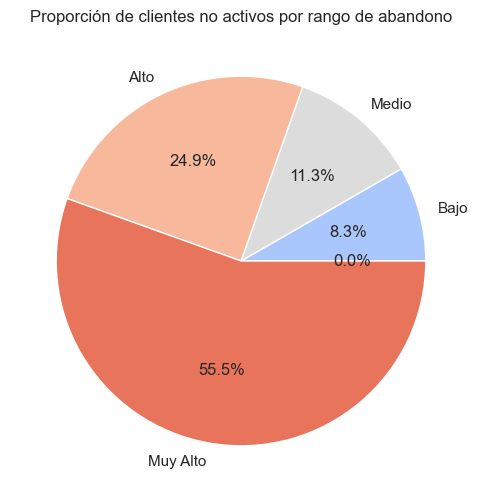

In [127]:
no_activos["Nivel_Riesgo"].value_counts().reindex(["Muy bajo","Bajo","Medio","Alto","Muy Alto"]).plot(
    kind="pie", autopct="%1.1f%%", figsize=(6,6), colors=sns.color_palette("coolwarm", 5)
)
plt.ylabel("")
plt.title("Proporción de clientes no activos por rango de abandono")
plt.show()

In [103]:
df_modelo[df_modelo['VidaGymMeses']<=2]


,IdPersona,Edad,FechaInscripcion,TipoAbonoActual,Sexo_Mujer,FAntiguedad,NumAltasAntesDelPeriodo,TuvoAltasPrevias,MesesDesdeUltimaAltaPrevia,MesesDuracionAbonoActual,...,DiaFav_lunes,DiaFav_martes,DiaFav_miércoles,DiaFav_sábado,DiaFav_viernes,EstFav_invierno,EstFav_otono,EstFav_primavera,EstFav_verano,TieneAccesos
0,109390,57,2025-09-01,MA00,True,2022-06-20,0.0,False,-1.0,0.0,...,False,False,False,False,False,True,False,False,False,True
1,116058,35,2025-09-01,AA00,True,2025-02-15,0.0,False,-1.0,0.0,...,True,False,False,False,False,False,False,True,False,True
2,96089,46,2025-09-01,AC03,False,2018-03-15,1.0,True,77.0,0.0,...,False,False,True,False,False,False,False,False,True,True
3,96101,49,2025-09-01,AA00,True,2025-09-01,0.0,False,-1.0,0.0,...,False,False,False,False,False,False,False,False,False,False
4,96304,53,2025-09-01,AA00,True,2021-09-20,0.0,False,-1.0,0.0,...,True,False,False,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6924,117264,57,2025-08-04,AA00,True,2025-08-04,-1.0,False,-1.0,-1.0,...,False,False,False,False,False,False,False,False,False,False
6925,117275,51,2025-08-06,AA00,False,2025-08-06,-1.0,False,-1.0,-1.0,...,True,False,False,False,False,False,False,False,True,True
6926,117276,37,2025-08-06,AA00,True,2025-08-06,-1.0,False,-1.0,-1.0,...,True,False,False,False,False,False,False,False,True,True
6927,117282,36,2025-08-07,AA00,False,2025-08-07,-1.0,False,-1.0,-1.0,...,False,True,False,False,False,False,False,False,True,True


In [79]:
# Estadísticas básicas de churn real y predicho por nivel de riesgo
resumen_riesgo = df_activos.groupby('Nivel_Riesgo').agg(
    Cantidad=('IdPersona','count'),
    Churn_Real_Promedio=('Churn_Real','mean'),
    Churn_Predicho_Promedio=('Churn_Predicho','mean'),
    Prob_Churn_Promedio=('Prob_Churn','mean')
).reset_index()

display(resumen_riesgo)

,Nivel_Riesgo,Cantidad,Churn_Real_Promedio,Churn_Predicho_Promedio,Prob_Churn_Promedio
0,Muy Bajo,4191,0.0,0.000000,0.047215
1,Bajo,466,0.0,0.000000,0.275986
2,Medio,176,0.0,0.443182,0.494479
3,Alto,65,0.0,1.000000,0.687768
4,Muy Alto,34,0.0,1.000000,0.863399


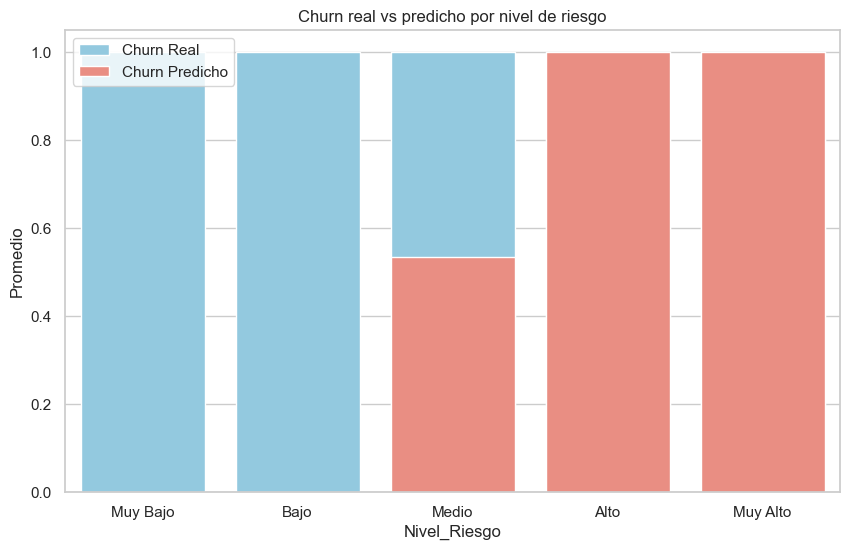

In [75]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=df_noactivos.groupby('Nivel_Riesgo')[['Churn_Real','Churn_Predicho']].mean().reset_index(),
    x='Nivel_Riesgo', y='Churn_Real', color='skyblue', label='Churn Real'
)
sns.barplot(
    data=df_noactivos.groupby('Nivel_Riesgo')[['Churn_Real','Churn_Predicho']].mean().reset_index(),
    x='Nivel_Riesgo', y='Churn_Predicho', color='salmon', label='Churn Predicho'
)
plt.title("Churn real vs predicho por nivel de riesgo")
plt.ylabel("Promedio")
plt.legend()
plt.show()

⚠️ Posibles columnas con fuga temporal: ['Irregularidad_ActivoIrregular', 'Irregularidad_ActivoRegular', 'Irregularidad_BajaFinalIrregular', 'Irregularidad_BajaFinalRegular', 'MesesDesdeUltimoAbono', 'Importe_2025_servicios', 'Cantidad_2025_servicios', 'NumRenovaciones', 'MesesDesdeUltimoPago', 'DuracionRenovacionMeses', 'DuracionMediaTotal', 'DuracionStdTotal', 'DuracionMediaUlt90', 'DeltaDuracionUlt90VsTotal']

--- Entrenando modelos base ---
LogReg: AUC=0.974 | F1=0.920 | Acc=0.937
KNN: AUC=0.901 | F1=0.804 | Acc=0.850
SVM: AUC=0.956 | F1=0.870 | Acc=0.899
RF: AUC=0.981 | F1=0.900 | Acc=0.924
GB: AUC=0.993 | F1=0.946 | Acc=0.958

Resultados iniciales:
    Modelo       AUC        F1  Accuracy
4      GB  0.992614  0.945967  0.957824
3      RF  0.980818  0.900161  0.924205
0  LogReg  0.974465  0.919969  0.937042
2     SVM  0.956011  0.869771  0.899144
1     KNN  0.900655  0.804157  0.850244

--- Optimizando Gradient Boosting ---
Fitting 5 folds for each of 10 candidates, totalling 50 f

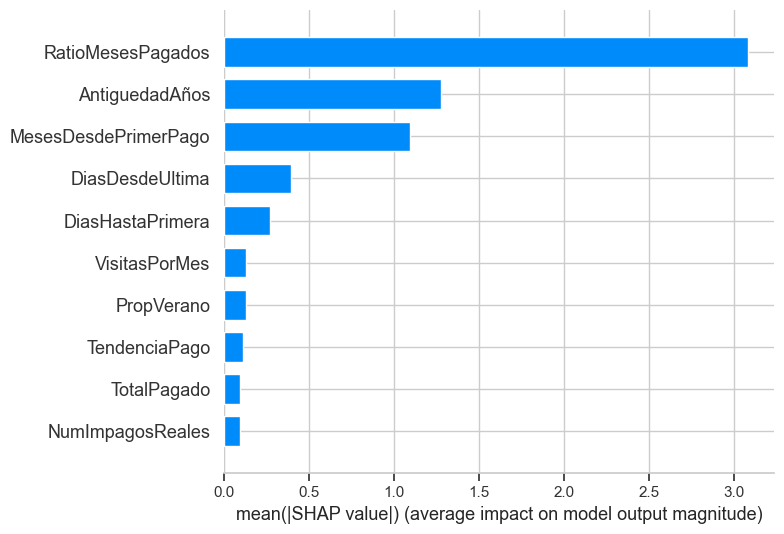

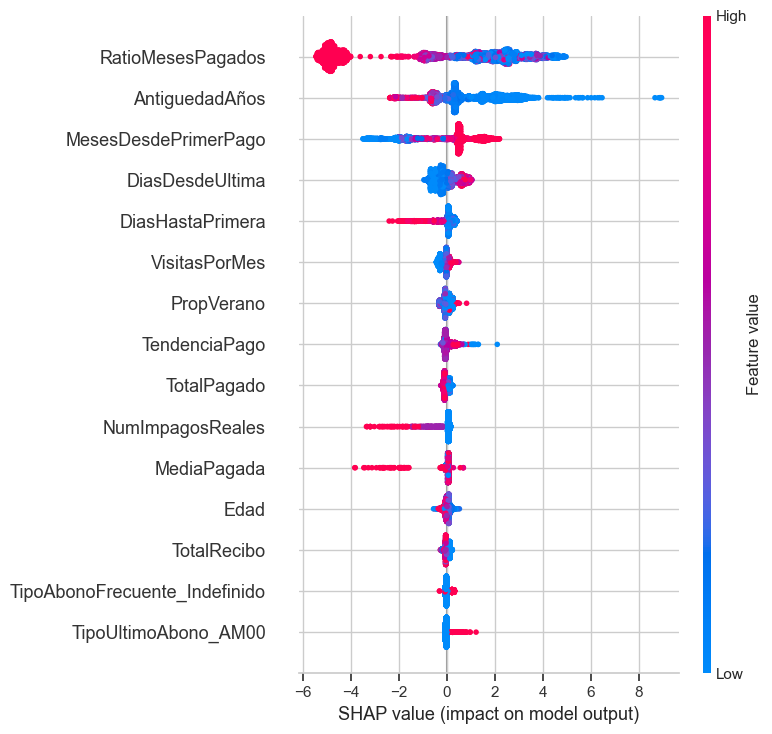


Top factores que más explican el churn:

                  Feature  Mean_SHAP
38      RatioMesesPagados   3.080581
2          AntiguedadAños   1.278487
40   MesesDesdePrimerPago   1.095307
94        DiasDesdeUltima   0.394417
95       DiasHastaPrimera   0.270680
86          VisitasPorMes   0.130066
108            PropVerano   0.130040
75          TendenciaPago   0.116077
31            TotalPagado   0.097995
77       NumImpagosReales   0.095748


In [31]:
# ============================================================
# 🧠 PREDICCIÓN DE CHURN – PIPELINE MEJORADO Y EXPLICABLE
# ============================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import shap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# ============================================================
# 1️⃣ CARGA Y PREPARACIÓN DE DATOS
# ============================================================


# --- 1.1. Eliminamos columnas vacías o constantes
df_temporal = df_temporal.dropna(axis=1, how="all")
constant_cols = [c for c in df_temporal.columns if df_temporal[c].nunique() <= 1]
df_temporal = df_temporal.drop(columns=constant_cols)

# --- 1.2. Eliminamos identificadores
drop_cols = ['IdPersona']  # ajusta según tus datos
df_temporal = df_temporal.drop(columns=[c for c in drop_cols if c in df_temporal.columns])

# --- 1.3. Detectamos columnas con riesgo de fuga temporal
suspect_words = ["_2025", "2025_", "desdeUltimo", "UltimoPago", "Duracion", "Renovacion", 'Irregularidad']
leak_cols = [c for c in df_temporal.columns if any(w.lower() in c.lower() for w in suspect_words)]
print(f"⚠️ Posibles columnas con fuga temporal: {leak_cols}")

# Las quitamos de momento (revisa si deben quedarse)
df_temporal = df_temporal.drop(columns=leak_cols)

# --- 1.4. Variables categóricas → one-hot encoding
df_temporal = pd.get_dummies(df_temporal, drop_first=True)

# --- 1.5. Target y features
y = df_temporal["Churn"]
X = df_temporal.drop(columns=["Churn"])

# ============================================================
# 2️⃣ SPLIT Y ESCALADO
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ============================================================
# 3️⃣ MODELOS BASE
# ============================================================

models = {
    "LogReg": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(probability=True, class_weight='balanced'),
    "RF": RandomForestClassifier(class_weight='balanced', random_state=42),
    "GB": GradientBoostingClassifier(random_state=42)
}

results = []

print("\n--- Entrenando modelos base ---")
for name, model in models.items():
    if name in ["LogReg", "KNN", "SVM"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
    
    auc = roc_auc_score(y_test, y_prob)
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    results.append((name, auc, f1, acc))
    print(f"{name}: AUC={auc:.3f} | F1={f1:.3f} | Acc={acc:.3f}")

results_df = pd.DataFrame(results, columns=["Modelo", "AUC", "F1", "Accuracy"])
print("\nResultados iniciales:\n", results_df.sort_values(by="AUC", ascending=False))

# ============================================================
# 4️⃣ VALIDACIÓN CRUZADA Y OPTIMIZACIÓN
# ============================================================

print("\n--- Optimizando Gradient Boosting ---")

param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [2, 3, 4],
    "subsample": [0.8, 1.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gb = GradientBoostingClassifier(random_state=42)

search = RandomizedSearchCV(
    gb,
    param_distributions=param_grid,
    scoring="roc_auc",
    n_iter=10,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

search.fit(X_train, y_train)
best_model = search.best_estimator_
print(f"Mejor modelo: {search.best_params_}")

# Validación cruzada final
cv_auc = cross_val_score(best_model, X_train, y_train, cv=cv, scoring="roc_auc")
print(f"AUC CV promedio: {cv_auc.mean():.3f} ± {cv_auc.std():.3f}")

# ============================================================
# 5️⃣ EVALUACIÓN FINAL
# ============================================================

y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("\n--- Resultados finales ---")
print("AUC:", roc_auc_score(y_test, y_prob))
print("F1:", f1_score(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

# ============================================================
# 6️⃣ INTERPRETABILIDAD (SHAP)
# ============================================================

print("\n--- Analizando importancia de variables ---")

# --- Paso 1: aseguramos que los datos sean numéricos (SHAP no acepta objetos)
X_train_shap = X_train.copy()
for col in X_train_shap.columns:
    if X_train_shap[col].dtype == "object":
        X_train_shap[col] = pd.to_numeric(X_train_shap[col], errors="coerce").fillna(0)

# --- Paso 2: elegimos el tipo de explicador adecuado
try:
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_train_shap)
    print("✅ Usando TreeExplainer (rápido y preciso para modelos tipo árbol).")
except Exception as e:
    print("⚠️ TreeExplainer falló, usando KernelExplainer (más lento pero universal).")
    # Usamos un muestreo de 200 observaciones para acelerar
    sample = X_train_shap.sample(200, random_state=42)
    explainer = shap.KernelExplainer(best_model.predict_proba, sample)
    shap_values = explainer.shap_values(sample, nsamples=100)

# --- Paso 3: convertimos los valores SHAP a matriz compatible
if isinstance(shap_values, list):  # Algunos modelos devuelven lista por clase
    shap_values = shap_values[1]  # clase positiva (churn)

# --- Paso 4: resumen gráfico
shap.summary_plot(shap_values, X_train_shap, plot_type="bar", max_display=10)
shap.summary_plot(shap_values, X_train_shap, max_display=15)

# --- Paso 5: ranking de importancia medio
importance = pd.DataFrame({
    "Feature": X_train_shap.columns,
    "Mean_SHAP": np.abs(shap_values).mean(axis=0)
}).sort_values(by="Mean_SHAP", ascending=False)

print("\nTop factores que más explican el churn:\n")
print(importance.head(10))


In [42]:
df_comparison[df_comparison['Churn'] != df_comparison['Churn_Pred']]

,IdPersona,Edad,Sexo_Mujer,AntiguedadAños,Churn,Churn_Pred,Churn_Prob
77,13268,58.0,True,41.24,0,1,0.641792
86,14254,74.0,True,39.69,0,1,0.554966
345,29537,74.0,True,17.94,0,1,0.635971
481,31502,20.0,False,1.80,0,1,0.943452
523,32429,18.0,True,3.41,0,1,0.936362
...,...,...,...,...,...,...,...
7956,117348,36.0,False,0.00,1,0,0.135201
7957,117352,50.0,True,0.01,1,0,0.250139
7958,117370,73.0,True,0.00,1,0,0.495874
7959,117421,26.0,True,0.00,1,0,0.378960
